In [1]:
import os

import numpy as np
from sklearn.decomposition import PCA

import matplotlib
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt

from utils import load_hidden_representations_from_hdf5, read_templates_from_file

----

In [2]:
# params
log_dir = "/logfiles"
model = "bigscience-T0"
module = "decoder"
task = "wic"

In [3]:
# assertions
assert model == "bigscience-T0"
assert module == "decoder"
assert task == "wic"

## Prompts

In [4]:
df = read_templates_from_file(f"/t0-analysis/prompts/{task}/all.csv")
# df = read_templates_from_file(f"/t0-analysis/prompts/{task}/fixed_prompt.csv")
# df = read_templates_from_file(f"/t0-analysis/prompts/{task}/fixed_target_yes_no.csv")
display(df)

name  \
0                  gpt_3_without_targets   
1              gpt_3_yes_no_with_targets   
2               affirmation_with_targets   
3          grammar_homework_with_targets   
4                polysemous_with_targets   
5       question_context_without_targets   
6       question_meaning_without_targets   
7   question_meaning_yes_no_with_targets   
8                same_sense_with_targets   
9          similar_sense_without_targets   
10     similar_sense_yes_no_with_targets   
11         gpt_3_true_false_with_targets   
12            gpt_3_cat_dog_with_targets   

                                             template     category  \
0   {sentence1} {sentence2} Question: Is the word ...  instructive   
1   {sentence1} {sentence2} Question: Is the word ...  instructive   
2   Sentence A: {sentence1} Sentence B: {sentence2...  instructive   
3   Decide whether the word "{word}" is used with ...  instructive   
4   The word "{word}" has multiple meanings. Does ...  instructive   
5   Determine if the word "{word}" is used in the ...  instructive   
6   Determine if the word "{word}" have the same m...  instructive   
7   Does the word "{word}" have the same meanining...  instructive   
8   Sentence 1: {sentence1} Sentence 2: {sentence2...  instructive   
9    {sentence1} {sentence2} Similar sense of {word}?  instructive   
10  {sentence1} {sentence2} Similar sense of {word...  instructive   
11  {sentence1} {sentence2} Question: Is the word ...  instructive   
12  {sentence1} {sentence2} Question: Is the word ...  instructive   

    includes_targets               targets  target_ids  shuffle  
0              False  ▁No, ▁no, ▁Yes, ▁yes  0, 0, 1, 1    False  
1               True             ▁No, ▁Yes        0, 1    False  
2               True           ▁Fal, ▁True        0, 1    False  
3               True             ▁No, ▁Yes        0, 1    False  
4               True             ▁No, ▁Yes        0, 1    False  
5              False  ▁No, ▁no, ▁Yes, ▁yes  0, 0, 1, 1    False  
6              False  ▁No, ▁no, ▁Yes, ▁yes  0, 0, 1, 1    False  
7               True             ▁No, ▁Yes        0, 1    False  
8               True             ▁No, ▁Yes        0, 1    False  
9              False  ▁No, ▁no, ▁Yes, ▁yes  0, 0, 1, 1    False  
10              True             ▁No, ▁Yes        0, 1    False  
11              True           ▁Fal, ▁True        0, 1    False  
12              True            ▁Cat, ▁Dog        0, 1    False

## PCA

In [5]:
def unison_shuffled_copies(a, b):
    # from: https://stackoverflow.com/questions/4601373/better-way-to-shuffle-two-numpy-arrays-in-unison
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

In [6]:
use_pattern = [
    "gpt_3_without_targets",
    "gpt_3_yes_no_with_targets",
    # "affirmation_with_targets",
    "grammar_homework_with_targets",
    # "polysemous_with_targets",
    # "question_context_without_targets",
    # "question_meaning_without_targets",
    # "question_meaning_yes_no_with_targets",
    # "same_sense_with_targets",
    # "similar_sense_without_targets",
    # "similar_sense_yes_no_with_targets",
    "gpt_3_true_false_with_targets",
    "gpt_3_cat_dog_with_targets",
]

In [7]:
for t in range(2):
# for t in range(1):
    # for layer in range(0, 2):
    for layer in range(0, 25):
    # for layer in range(24, 25):
        print(f"token: {t}\tlayer: {layer}")
        file_names, prompt_names = [], []

        for _, row in df.iterrows():
            if row['name'] in use_pattern:
                file_names.append(f"{task}/{model}/{module}/{row['name']}/hidden_represenations_t{t}_layer{layer}_avg.hdf5",)
                prompt_names.append(row['name'])


        # load hidden representations from hdf5 file
        representations = None
        classes = []
        n_sequences = 0

        for idx, file_name in enumerate(file_names):
            hidden_representations = load_hidden_representations_from_hdf5(os.path.join(log_dir, file_name))
            # print(hidden_representations.shape)
            n_sequences = hidden_representations.shape[0]

            if representations is None:
                representations = hidden_representations
            else:
                representations = np.concatenate((representations, hidden_representations), axis=0)

            classes += n_sequences * [idx] # assign representations to classes
        
        classes = np.asarray(classes)

        X, y = representations, classes
        # shuffle representations and classes
        # X, y = unison_shuffled_copies(representations, classes)
        print(X.shape, y.shape)

        # perform PCA on hidden representations
        print('PCA for prompts:', prompt_names)

        for n_components in range(2, 3):
            pca = PCA(n_components=n_components)
            pca.fit(X)

            # variance explained by each of the principal components
            print(f"model:{model}; module:{module}; token:{t}; layer:{layer}; n_components: {n_components}; variance explained: {pca.explained_variance_ratio_}")
            print(np.sum(pca.explained_variance_ratio_))
        print('\n')


token: 0	layer: 0


Reading embeddings: 100%|██████████| 638/638 [00:00<00:00, 5823.58it/s]
/opt/conda/lib/python3.6/site-packages/sklearn/decomposition/_pca.py:555: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ / total_var.sum()


(3190, 4096) (3190,)
PCA for prompts: ['gpt_3_without_targets', 'gpt_3_yes_no_with_targets', 'grammar_homework_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets']
model:bigscience-T0; module:decoder; token:0; layer:0; n_components: 2; variance explained: [nan nan]
nan


token: 0	layer: 1


Reading embeddings: 100%|██████████| 638/638 [00:00<00:00, 5764.27it/s]


(3190, 4096) (3190,)
PCA for prompts: ['gpt_3_without_targets', 'gpt_3_yes_no_with_targets', 'grammar_homework_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets']
model:bigscience-T0; module:decoder; token:0; layer:1; n_components: 2; variance explained: [0.94602597 0.01671421]
0.9627402


token: 0	layer: 2


Reading embeddings: 100%|██████████| 638/638 [00:00<00:00, 5826.74it/s]


(3190, 4096) (3190,)
PCA for prompts: ['gpt_3_without_targets', 'gpt_3_yes_no_with_targets', 'grammar_homework_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets']
model:bigscience-T0; module:decoder; token:0; layer:2; n_components: 2; variance explained: [0.89284384 0.06585561]
0.95869946


token: 0	layer: 3


Reading embeddings: 100%|██████████| 638/638 [00:00<00:00, 5827.01it/s]


(3190, 4096) (3190,)
PCA for prompts: ['gpt_3_without_targets', 'gpt_3_yes_no_with_targets', 'grammar_homework_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets']
model:bigscience-T0; module:decoder; token:0; layer:3; n_components: 2; variance explained: [0.9495621  0.02356051]
0.9731226


token: 0	layer: 4


Reading embeddings: 100%|██████████| 638/638 [00:00<00:00, 5831.80it/s]


(3190, 4096) (3190,)
PCA for prompts: ['gpt_3_without_targets', 'gpt_3_yes_no_with_targets', 'grammar_homework_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets']
model:bigscience-T0; module:decoder; token:0; layer:4; n_components: 2; variance explained: [0.9859702  0.00433844]
0.99030864


token: 0	layer: 5


Reading embeddings: 100%|██████████| 638/638 [00:00<00:00, 5846.95it/s]


(3190, 4096) (3190,)
PCA for prompts: ['gpt_3_without_targets', 'gpt_3_yes_no_with_targets', 'grammar_homework_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets']
model:bigscience-T0; module:decoder; token:0; layer:5; n_components: 2; variance explained: [0.98417306 0.00464387]
0.9888169


token: 0	layer: 6


Reading embeddings: 100%|██████████| 638/638 [00:00<00:00, 5893.16it/s]


(3190, 4096) (3190,)
PCA for prompts: ['gpt_3_without_targets', 'gpt_3_yes_no_with_targets', 'grammar_homework_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets']
model:bigscience-T0; module:decoder; token:0; layer:6; n_components: 2; variance explained: [0.9893429  0.00320033]
0.9925433


token: 0	layer: 7


Reading embeddings: 100%|██████████| 638/638 [00:00<00:00, 5891.27it/s]


(3190, 4096) (3190,)
PCA for prompts: ['gpt_3_without_targets', 'gpt_3_yes_no_with_targets', 'grammar_homework_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets']
model:bigscience-T0; module:decoder; token:0; layer:7; n_components: 2; variance explained: [0.9895448  0.00556551]
0.99511033


token: 0	layer: 8


Reading embeddings: 100%|██████████| 638/638 [00:00<00:00, 5580.94it/s]


(3190, 4096) (3190,)
PCA for prompts: ['gpt_3_without_targets', 'gpt_3_yes_no_with_targets', 'grammar_homework_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets']
model:bigscience-T0; module:decoder; token:0; layer:8; n_components: 2; variance explained: [0.99028313 0.00439072]
0.99467385


token: 0	layer: 9


Reading embeddings: 100%|██████████| 638/638 [00:00<00:00, 5874.01it/s]


(3190, 4096) (3190,)
PCA for prompts: ['gpt_3_without_targets', 'gpt_3_yes_no_with_targets', 'grammar_homework_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets']
model:bigscience-T0; module:decoder; token:0; layer:9; n_components: 2; variance explained: [0.9906837  0.00397926]
0.99466294


token: 0	layer: 10


Reading embeddings: 100%|██████████| 638/638 [00:00<00:00, 5873.91it/s]


(3190, 4096) (3190,)
PCA for prompts: ['gpt_3_without_targets', 'gpt_3_yes_no_with_targets', 'grammar_homework_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets']
model:bigscience-T0; module:decoder; token:0; layer:10; n_components: 2; variance explained: [0.9915149  0.00346159]
0.9949765


token: 0	layer: 11


Reading embeddings: 100%|██████████| 638/638 [00:00<00:00, 5728.60it/s]


(3190, 4096) (3190,)
PCA for prompts: ['gpt_3_without_targets', 'gpt_3_yes_no_with_targets', 'grammar_homework_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets']
model:bigscience-T0; module:decoder; token:0; layer:11; n_components: 2; variance explained: [0.9923444  0.00304054]
0.99538493


token: 0	layer: 12


Reading embeddings: 100%|██████████| 638/638 [00:00<00:00, 5938.86it/s]


(3190, 4096) (3190,)
PCA for prompts: ['gpt_3_without_targets', 'gpt_3_yes_no_with_targets', 'grammar_homework_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets']
model:bigscience-T0; module:decoder; token:0; layer:12; n_components: 2; variance explained: [0.99261767 0.00279086]
0.99540854


token: 0	layer: 13


Reading embeddings: 100%|██████████| 638/638 [00:00<00:00, 5985.00it/s]


(3190, 4096) (3190,)
PCA for prompts: ['gpt_3_without_targets', 'gpt_3_yes_no_with_targets', 'grammar_homework_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets']
model:bigscience-T0; module:decoder; token:0; layer:13; n_components: 2; variance explained: [0.99049205 0.0031109 ]
0.99360293


token: 0	layer: 14


Reading embeddings: 100%|██████████| 638/638 [00:00<00:00, 5873.90it/s]


(3190, 4096) (3190,)
PCA for prompts: ['gpt_3_without_targets', 'gpt_3_yes_no_with_targets', 'grammar_homework_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets']
model:bigscience-T0; module:decoder; token:0; layer:14; n_components: 2; variance explained: [0.99030995 0.00311923]
0.9934292


token: 0	layer: 15


Reading embeddings: 100%|██████████| 638/638 [00:00<00:00, 5993.00it/s]


(3190, 4096) (3190,)
PCA for prompts: ['gpt_3_without_targets', 'gpt_3_yes_no_with_targets', 'grammar_homework_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets']
model:bigscience-T0; module:decoder; token:0; layer:15; n_components: 2; variance explained: [0.9880616  0.00373427]
0.9917959


token: 0	layer: 16


Reading embeddings: 100%|██████████| 638/638 [00:00<00:00, 5773.02it/s]


(3190, 4096) (3190,)
PCA for prompts: ['gpt_3_without_targets', 'gpt_3_yes_no_with_targets', 'grammar_homework_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets']
model:bigscience-T0; module:decoder; token:0; layer:16; n_components: 2; variance explained: [0.9849763  0.00403902]
0.98901534


token: 0	layer: 17


Reading embeddings: 100%|██████████| 638/638 [00:00<00:00, 5439.18it/s]


(3190, 4096) (3190,)
PCA for prompts: ['gpt_3_without_targets', 'gpt_3_yes_no_with_targets', 'grammar_homework_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets']
model:bigscience-T0; module:decoder; token:0; layer:17; n_components: 2; variance explained: [0.98492646 0.00400277]
0.9889292


token: 0	layer: 18


Reading embeddings: 100%|██████████| 638/638 [00:00<00:00, 5923.54it/s]


(3190, 4096) (3190,)
PCA for prompts: ['gpt_3_without_targets', 'gpt_3_yes_no_with_targets', 'grammar_homework_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets']
model:bigscience-T0; module:decoder; token:0; layer:18; n_components: 2; variance explained: [0.9354393  0.01125383]
0.9466931


token: 0	layer: 19


Reading embeddings: 100%|██████████| 638/638 [00:00<00:00, 5807.03it/s]


(3190, 4096) (3190,)
PCA for prompts: ['gpt_3_without_targets', 'gpt_3_yes_no_with_targets', 'grammar_homework_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets']
model:bigscience-T0; module:decoder; token:0; layer:19; n_components: 2; variance explained: [0.8092847  0.04065675]
0.84994143


token: 0	layer: 20


Reading embeddings: 100%|██████████| 638/638 [00:00<00:00, 5896.64it/s]


(3190, 4096) (3190,)
PCA for prompts: ['gpt_3_without_targets', 'gpt_3_yes_no_with_targets', 'grammar_homework_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets']
model:bigscience-T0; module:decoder; token:0; layer:20; n_components: 2; variance explained: [0.5671025  0.11518396]
0.68228644


token: 0	layer: 21


Reading embeddings: 100%|██████████| 638/638 [00:00<00:00, 5173.95it/s]


(3190, 4096) (3190,)
PCA for prompts: ['gpt_3_without_targets', 'gpt_3_yes_no_with_targets', 'grammar_homework_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets']
model:bigscience-T0; module:decoder; token:0; layer:21; n_components: 2; variance explained: [0.44561243 0.10637587]
0.5519883


token: 0	layer: 22


Reading embeddings: 100%|██████████| 638/638 [00:00<00:00, 5216.28it/s]


(3190, 4096) (3190,)
PCA for prompts: ['gpt_3_without_targets', 'gpt_3_yes_no_with_targets', 'grammar_homework_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets']
model:bigscience-T0; module:decoder; token:0; layer:22; n_components: 2; variance explained: [0.48300162 0.12489978]
0.6079014


token: 0	layer: 23


Reading embeddings: 100%|██████████| 638/638 [00:00<00:00, 5832.52it/s]


(3190, 4096) (3190,)
PCA for prompts: ['gpt_3_without_targets', 'gpt_3_yes_no_with_targets', 'grammar_homework_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets']
model:bigscience-T0; module:decoder; token:0; layer:23; n_components: 2; variance explained: [0.5684837  0.04322365]
0.6117073


token: 0	layer: 24


Reading embeddings: 100%|██████████| 638/638 [00:00<00:00, 5855.83it/s]


(3190, 4096) (3190,)
PCA for prompts: ['gpt_3_without_targets', 'gpt_3_yes_no_with_targets', 'grammar_homework_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets']
model:bigscience-T0; module:decoder; token:0; layer:24; n_components: 2; variance explained: [0.7567289  0.04052026]
0.79724914


token: 1	layer: 0


Reading embeddings: 100%|██████████| 638/638 [00:00<00:00, 5636.91it/s]


(3190, 4096) (3190,)
PCA for prompts: ['gpt_3_without_targets', 'gpt_3_yes_no_with_targets', 'grammar_homework_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets']
model:bigscience-T0; module:decoder; token:1; layer:0; n_components: 2; variance explained: [0.70331824 0.11746641]
0.8207846


token: 1	layer: 1


Reading embeddings: 100%|██████████| 638/638 [00:00<00:00, 5429.66it/s]


(3190, 4096) (3190,)
PCA for prompts: ['gpt_3_without_targets', 'gpt_3_yes_no_with_targets', 'grammar_homework_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets']
model:bigscience-T0; module:decoder; token:1; layer:1; n_components: 2; variance explained: [0.72473    0.11468779]
0.8394178


token: 1	layer: 2


Reading embeddings: 100%|██████████| 638/638 [00:00<00:00, 5998.43it/s]


(3190, 4096) (3190,)
PCA for prompts: ['gpt_3_without_targets', 'gpt_3_yes_no_with_targets', 'grammar_homework_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets']
model:bigscience-T0; module:decoder; token:1; layer:2; n_components: 2; variance explained: [0.7957123  0.09558113]
0.8912934


token: 1	layer: 3


Reading embeddings: 100%|██████████| 638/638 [00:00<00:00, 5796.54it/s]


(3190, 4096) (3190,)
PCA for prompts: ['gpt_3_without_targets', 'gpt_3_yes_no_with_targets', 'grammar_homework_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets']
model:bigscience-T0; module:decoder; token:1; layer:3; n_components: 2; variance explained: [0.88652897 0.05649494]
0.9430239


token: 1	layer: 4


Reading embeddings: 100%|██████████| 638/638 [00:00<00:00, 5648.91it/s]


(3190, 4096) (3190,)
PCA for prompts: ['gpt_3_without_targets', 'gpt_3_yes_no_with_targets', 'grammar_homework_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets']
model:bigscience-T0; module:decoder; token:1; layer:4; n_components: 2; variance explained: [0.94013333 0.03018514]
0.9703185


token: 1	layer: 5


Reading embeddings: 100%|██████████| 638/638 [00:00<00:00, 5472.50it/s]


(3190, 4096) (3190,)
PCA for prompts: ['gpt_3_without_targets', 'gpt_3_yes_no_with_targets', 'grammar_homework_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets']
model:bigscience-T0; module:decoder; token:1; layer:5; n_components: 2; variance explained: [0.96095    0.02019962]
0.9811496


token: 1	layer: 6


Reading embeddings: 100%|██████████| 638/638 [00:00<00:00, 5526.54it/s]


(3190, 4096) (3190,)
PCA for prompts: ['gpt_3_without_targets', 'gpt_3_yes_no_with_targets', 'grammar_homework_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets']
model:bigscience-T0; module:decoder; token:1; layer:6; n_components: 2; variance explained: [0.970755   0.01510907]
0.98586404


token: 1	layer: 7


Reading embeddings: 100%|██████████| 638/638 [00:00<00:00, 5654.37it/s]


(3190, 4096) (3190,)
PCA for prompts: ['gpt_3_without_targets', 'gpt_3_yes_no_with_targets', 'grammar_homework_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets']
model:bigscience-T0; module:decoder; token:1; layer:7; n_components: 2; variance explained: [0.9802335  0.01092492]
0.9911584


token: 1	layer: 8


Reading embeddings: 100%|██████████| 638/638 [00:00<00:00, 5387.06it/s]


(3190, 4096) (3190,)
PCA for prompts: ['gpt_3_without_targets', 'gpt_3_yes_no_with_targets', 'grammar_homework_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets']
model:bigscience-T0; module:decoder; token:1; layer:8; n_components: 2; variance explained: [0.9828574  0.00924833]
0.9921057


token: 1	layer: 9


Reading embeddings: 100%|██████████| 638/638 [00:00<00:00, 5765.08it/s]


(3190, 4096) (3190,)
PCA for prompts: ['gpt_3_without_targets', 'gpt_3_yes_no_with_targets', 'grammar_homework_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets']
model:bigscience-T0; module:decoder; token:1; layer:9; n_components: 2; variance explained: [0.98542744 0.00765104]
0.9930785


token: 1	layer: 10


Reading embeddings: 100%|██████████| 638/638 [00:00<00:00, 5774.73it/s]


(3190, 4096) (3190,)
PCA for prompts: ['gpt_3_without_targets', 'gpt_3_yes_no_with_targets', 'grammar_homework_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets']
model:bigscience-T0; module:decoder; token:1; layer:10; n_components: 2; variance explained: [0.9869259 0.0066324]
0.9935583


token: 1	layer: 11


Reading embeddings: 100%|██████████| 638/638 [00:00<00:00, 5960.70it/s]


(3190, 4096) (3190,)
PCA for prompts: ['gpt_3_without_targets', 'gpt_3_yes_no_with_targets', 'grammar_homework_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets']
model:bigscience-T0; module:decoder; token:1; layer:11; n_components: 2; variance explained: [0.9871007  0.00635905]
0.99345976


token: 1	layer: 12


Reading embeddings: 100%|██████████| 638/638 [00:00<00:00, 5857.77it/s]


(3190, 4096) (3190,)
PCA for prompts: ['gpt_3_without_targets', 'gpt_3_yes_no_with_targets', 'grammar_homework_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets']
model:bigscience-T0; module:decoder; token:1; layer:12; n_components: 2; variance explained: [0.98597133 0.00654017]
0.9925115


token: 1	layer: 13


Reading embeddings: 100%|██████████| 638/638 [00:00<00:00, 5594.73it/s]


(3190, 4096) (3190,)
PCA for prompts: ['gpt_3_without_targets', 'gpt_3_yes_no_with_targets', 'grammar_homework_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets']
model:bigscience-T0; module:decoder; token:1; layer:13; n_components: 2; variance explained: [0.98016137 0.00913415]
0.98929554


token: 1	layer: 14


Reading embeddings: 100%|██████████| 638/638 [00:00<00:00, 5319.85it/s]


(3190, 4096) (3190,)
PCA for prompts: ['gpt_3_without_targets', 'gpt_3_yes_no_with_targets', 'grammar_homework_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets']
model:bigscience-T0; module:decoder; token:1; layer:14; n_components: 2; variance explained: [0.97120017 0.01311167]
0.9843118


token: 1	layer: 15


Reading embeddings: 100%|██████████| 638/638 [00:00<00:00, 5949.50it/s]


(3190, 4096) (3190,)
PCA for prompts: ['gpt_3_without_targets', 'gpt_3_yes_no_with_targets', 'grammar_homework_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets']
model:bigscience-T0; module:decoder; token:1; layer:15; n_components: 2; variance explained: [0.94445205 0.02689469]
0.97134674


token: 1	layer: 16


Reading embeddings: 100%|██████████| 638/638 [00:00<00:00, 6027.00it/s]


(3190, 4096) (3190,)
PCA for prompts: ['gpt_3_without_targets', 'gpt_3_yes_no_with_targets', 'grammar_homework_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets']
model:bigscience-T0; module:decoder; token:1; layer:16; n_components: 2; variance explained: [0.86501366 0.06673457]
0.9317482


token: 1	layer: 17


Reading embeddings: 100%|██████████| 638/638 [00:00<00:00, 5792.62it/s]


(3190, 4096) (3190,)
PCA for prompts: ['gpt_3_without_targets', 'gpt_3_yes_no_with_targets', 'grammar_homework_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets']
model:bigscience-T0; module:decoder; token:1; layer:17; n_components: 2; variance explained: [0.77076447 0.11920901]
0.88997346


token: 1	layer: 18


Reading embeddings: 100%|██████████| 638/638 [00:00<00:00, 5899.62it/s]


(3190, 4096) (3190,)
PCA for prompts: ['gpt_3_without_targets', 'gpt_3_yes_no_with_targets', 'grammar_homework_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets']
model:bigscience-T0; module:decoder; token:1; layer:18; n_components: 2; variance explained: [0.6860521  0.18632865]
0.87238073


token: 1	layer: 19


Reading embeddings: 100%|██████████| 638/638 [00:00<00:00, 5822.11it/s]


(3190, 4096) (3190,)
PCA for prompts: ['gpt_3_without_targets', 'gpt_3_yes_no_with_targets', 'grammar_homework_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets']
model:bigscience-T0; module:decoder; token:1; layer:19; n_components: 2; variance explained: [0.5158061  0.34472308]
0.8605292


token: 1	layer: 20


Reading embeddings: 100%|██████████| 638/638 [00:00<00:00, 5957.08it/s]


(3190, 4096) (3190,)
PCA for prompts: ['gpt_3_without_targets', 'gpt_3_yes_no_with_targets', 'grammar_homework_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets']
model:bigscience-T0; module:decoder; token:1; layer:20; n_components: 2; variance explained: [0.55987906 0.31339678]
0.8732759


token: 1	layer: 21


Reading embeddings: 100%|██████████| 638/638 [00:00<00:00, 5834.30it/s]


(3190, 4096) (3190,)
PCA for prompts: ['gpt_3_without_targets', 'gpt_3_yes_no_with_targets', 'grammar_homework_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets']
model:bigscience-T0; module:decoder; token:1; layer:21; n_components: 2; variance explained: [0.5331101  0.27398586]
0.80709594


token: 1	layer: 22


Reading embeddings: 100%|██████████| 638/638 [00:00<00:00, 5780.50it/s]


(3190, 4096) (3190,)
PCA for prompts: ['gpt_3_without_targets', 'gpt_3_yes_no_with_targets', 'grammar_homework_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets']
model:bigscience-T0; module:decoder; token:1; layer:22; n_components: 2; variance explained: [0.5202594 0.2744113]
0.7946707


token: 1	layer: 23


Reading embeddings: 100%|██████████| 638/638 [00:00<00:00, 6035.57it/s]


(3190, 4096) (3190,)
PCA for prompts: ['gpt_3_without_targets', 'gpt_3_yes_no_with_targets', 'grammar_homework_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets']
model:bigscience-T0; module:decoder; token:1; layer:23; n_components: 2; variance explained: [0.47978204 0.3299522 ]
0.8097342


token: 1	layer: 24


Reading embeddings: 100%|██████████| 638/638 [00:00<00:00, 5818.96it/s]


(3190, 4096) (3190,)
PCA for prompts: ['gpt_3_without_targets', 'gpt_3_yes_no_with_targets', 'grammar_homework_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets']
model:bigscience-T0; module:decoder; token:1; layer:24; n_components: 2; variance explained: [0.7923797  0.12854023]
0.9209199




## Visualize PCA

token: 0	layer: 0


Reading embeddings: 100%|██████████| 638/638 [00:00<00:00, 5815.81it/s]
/opt/conda/lib/python3.6/site-packages/sklearn/decomposition/_pca.py:555: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ / total_var.sum()


(3190, 4096) (3190,)
PCA for prompts: ['gpt_3_without_targets', 'gpt_3_yes_no_with_targets', 'grammar_homework_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets']
(3190, 2)
model:bigscience-T0; module:decoder; token:0; layer:0; n_components: 2; variance explained: [nan nan]
nan


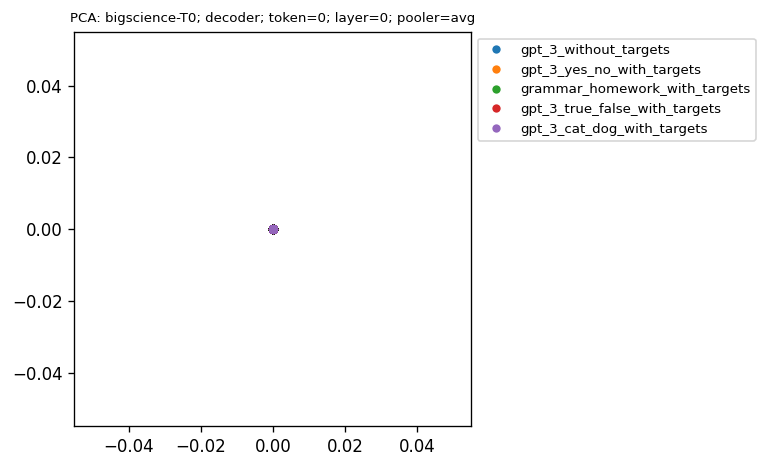



token: 0	layer: 1


Reading embeddings: 100%|██████████| 638/638 [00:00<00:00, 5912.33it/s]


(3190, 4096) (3190,)
PCA for prompts: ['gpt_3_without_targets', 'gpt_3_yes_no_with_targets', 'grammar_homework_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets']
(3190, 2)
model:bigscience-T0; module:decoder; token:0; layer:1; n_components: 2; variance explained: [0.94602597 0.01671421]
0.9627402


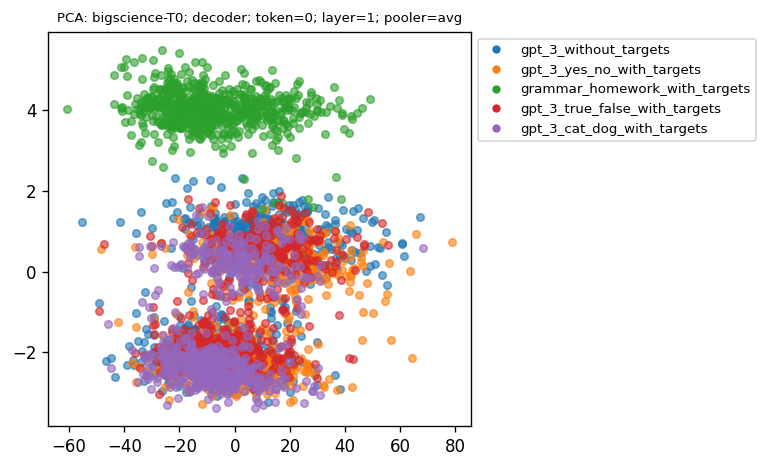



token: 0	layer: 2


Reading embeddings: 100%|██████████| 638/638 [00:00<00:00, 5103.94it/s]


(3190, 4096) (3190,)
PCA for prompts: ['gpt_3_without_targets', 'gpt_3_yes_no_with_targets', 'grammar_homework_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets']
(3190, 2)
model:bigscience-T0; module:decoder; token:0; layer:2; n_components: 2; variance explained: [0.8928438  0.06585561]
0.9586994


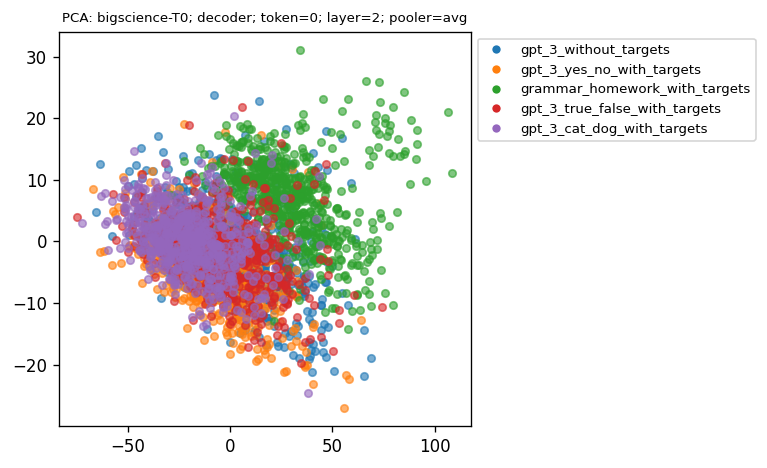



token: 0	layer: 3


Reading embeddings: 100%|██████████| 638/638 [00:00<00:00, 5607.04it/s]


(3190, 4096) (3190,)
PCA for prompts: ['gpt_3_without_targets', 'gpt_3_yes_no_with_targets', 'grammar_homework_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets']
(3190, 2)
model:bigscience-T0; module:decoder; token:0; layer:3; n_components: 2; variance explained: [0.9495621  0.02356051]
0.9731226


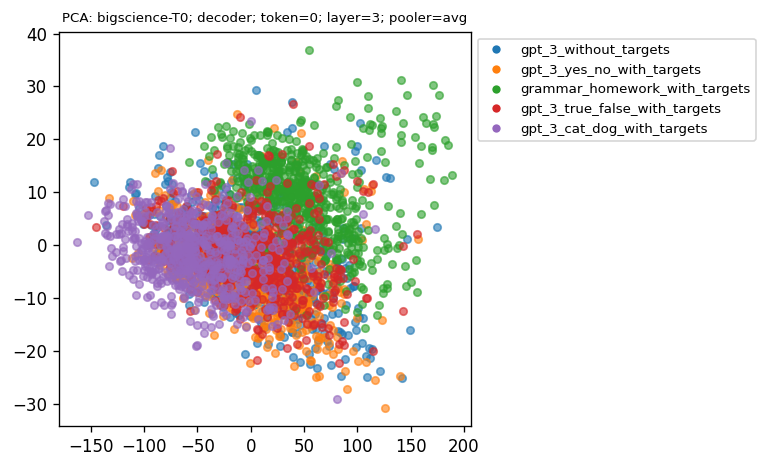



token: 0	layer: 4


Reading embeddings: 100%|██████████| 638/638 [00:00<00:00, 5865.38it/s]


(3190, 4096) (3190,)
PCA for prompts: ['gpt_3_without_targets', 'gpt_3_yes_no_with_targets', 'grammar_homework_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets']
(3190, 2)
model:bigscience-T0; module:decoder; token:0; layer:4; n_components: 2; variance explained: [0.9859702  0.00433844]
0.99030864


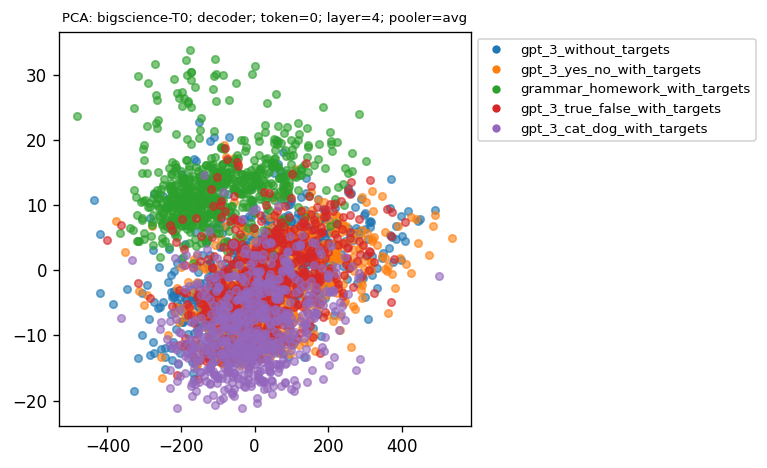



token: 0	layer: 5


Reading embeddings: 100%|██████████| 638/638 [00:00<00:00, 5811.09it/s]


(3190, 4096) (3190,)
PCA for prompts: ['gpt_3_without_targets', 'gpt_3_yes_no_with_targets', 'grammar_homework_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets']
(3190, 2)
model:bigscience-T0; module:decoder; token:0; layer:5; n_components: 2; variance explained: [0.98417306 0.00464387]
0.9888169


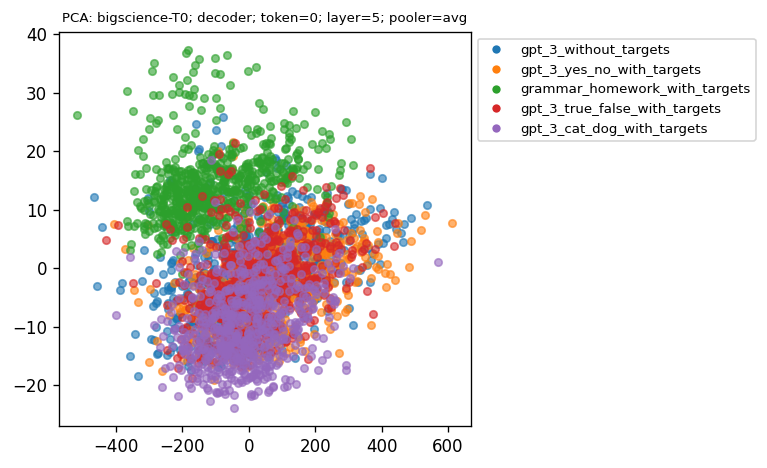



token: 0	layer: 6


Reading embeddings: 100%|██████████| 638/638 [00:00<00:00, 5722.82it/s]


(3190, 4096) (3190,)
PCA for prompts: ['gpt_3_without_targets', 'gpt_3_yes_no_with_targets', 'grammar_homework_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets']
(3190, 2)
model:bigscience-T0; module:decoder; token:0; layer:6; n_components: 2; variance explained: [0.9893431  0.00320033]
0.99254346


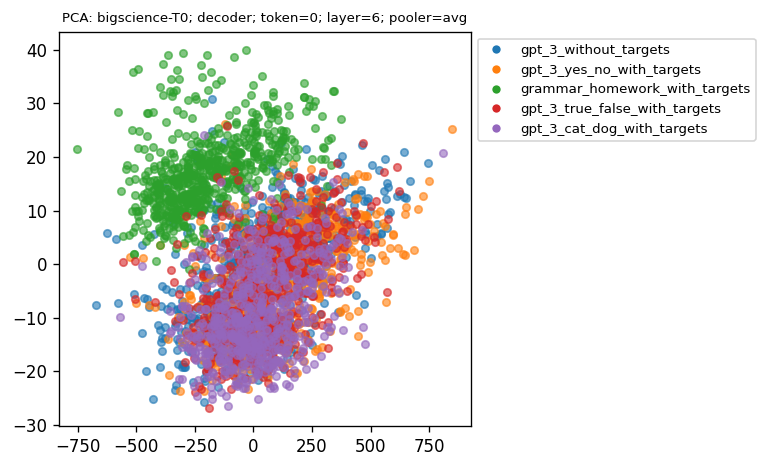



token: 0	layer: 7


Reading embeddings: 100%|██████████| 638/638 [00:00<00:00, 5909.88it/s]


(3190, 4096) (3190,)
PCA for prompts: ['gpt_3_without_targets', 'gpt_3_yes_no_with_targets', 'grammar_homework_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets']
(3190, 2)
model:bigscience-T0; module:decoder; token:0; layer:7; n_components: 2; variance explained: [0.9895448  0.00556551]
0.99511033


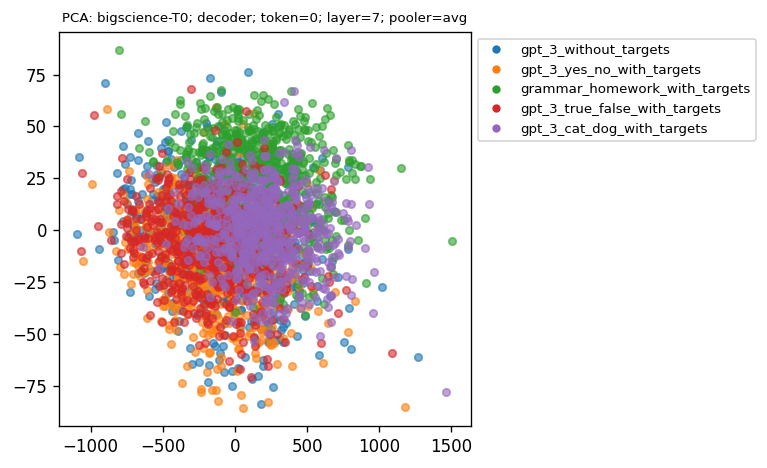



token: 0	layer: 8


Reading embeddings: 100%|██████████| 638/638 [00:00<00:00, 5317.62it/s]


(3190, 4096) (3190,)
PCA for prompts: ['gpt_3_without_targets', 'gpt_3_yes_no_with_targets', 'grammar_homework_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets']
(3190, 2)
model:bigscience-T0; module:decoder; token:0; layer:8; n_components: 2; variance explained: [0.99028313 0.00439072]
0.99467385


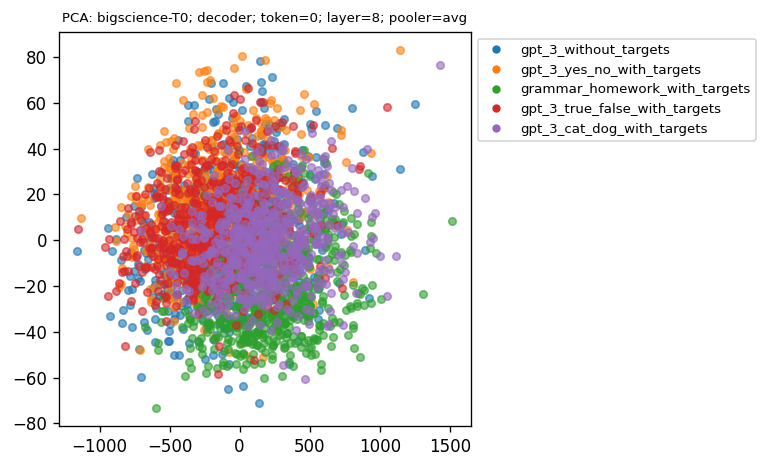



token: 0	layer: 9


Reading embeddings: 100%|██████████| 638/638 [00:00<00:00, 5694.07it/s]


(3190, 4096) (3190,)
PCA for prompts: ['gpt_3_without_targets', 'gpt_3_yes_no_with_targets', 'grammar_homework_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets']
(3190, 2)
model:bigscience-T0; module:decoder; token:0; layer:9; n_components: 2; variance explained: [0.9906837  0.00397926]
0.99466294


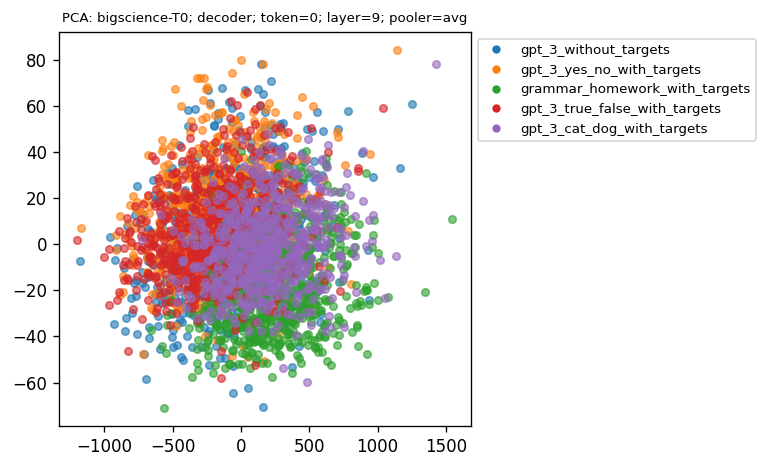



token: 0	layer: 10


Reading embeddings: 100%|██████████| 638/638 [00:00<00:00, 5706.41it/s]


(3190, 4096) (3190,)
PCA for prompts: ['gpt_3_without_targets', 'gpt_3_yes_no_with_targets', 'grammar_homework_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets']
(3190, 2)
model:bigscience-T0; module:decoder; token:0; layer:10; n_components: 2; variance explained: [0.9915149  0.00346159]
0.9949765


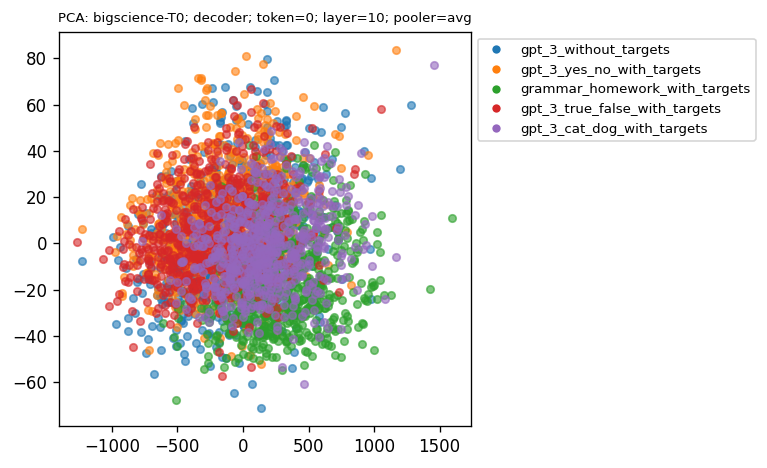



token: 0	layer: 11


Reading embeddings: 100%|██████████| 638/638 [00:00<00:00, 5701.61it/s]


(3190, 4096) (3190,)
PCA for prompts: ['gpt_3_without_targets', 'gpt_3_yes_no_with_targets', 'grammar_homework_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets']
(3190, 2)
model:bigscience-T0; module:decoder; token:0; layer:11; n_components: 2; variance explained: [0.9923447  0.00304054]
0.9953852


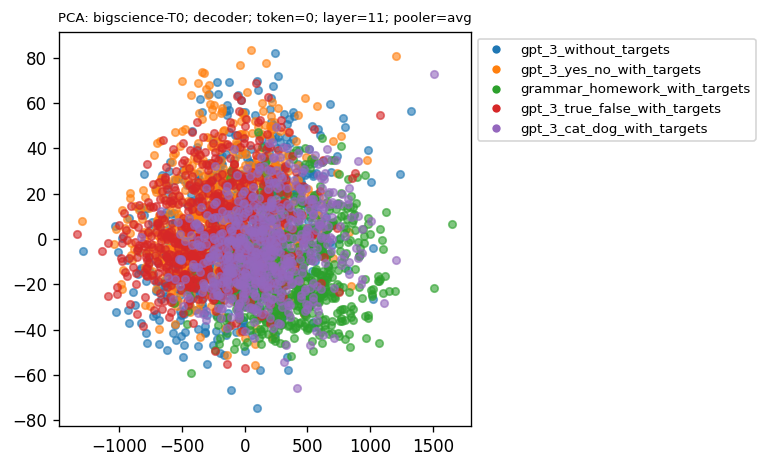



token: 0	layer: 12


Reading embeddings: 100%|██████████| 638/638 [00:00<00:00, 5042.35it/s]


(3190, 4096) (3190,)
PCA for prompts: ['gpt_3_without_targets', 'gpt_3_yes_no_with_targets', 'grammar_homework_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets']
(3190, 2)
model:bigscience-T0; module:decoder; token:0; layer:12; n_components: 2; variance explained: [0.99261767 0.00279086]
0.99540854


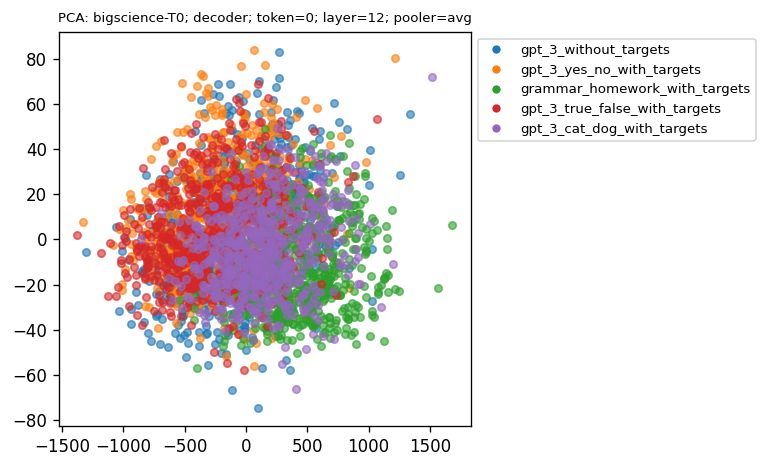



token: 0	layer: 13


Reading embeddings: 100%|██████████| 638/638 [00:00<00:00, 5100.11it/s]


(3190, 4096) (3190,)
PCA for prompts: ['gpt_3_without_targets', 'gpt_3_yes_no_with_targets', 'grammar_homework_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets']
(3190, 2)
model:bigscience-T0; module:decoder; token:0; layer:13; n_components: 2; variance explained: [0.99049205 0.0031109 ]
0.99360293


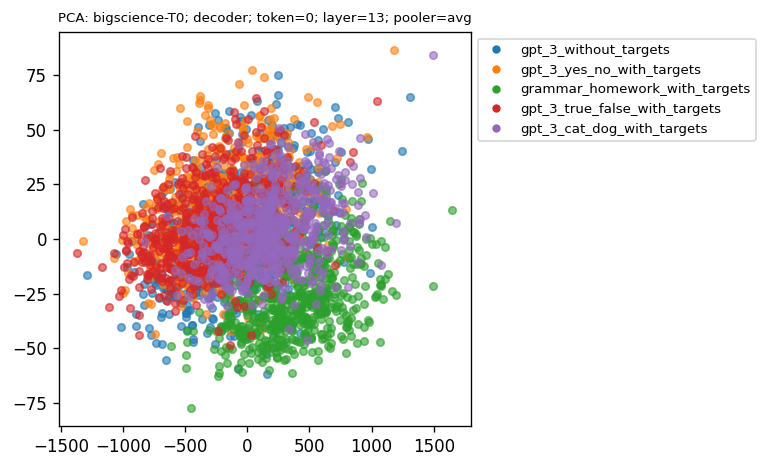



token: 0	layer: 14


Reading embeddings: 100%|██████████| 638/638 [00:00<00:00, 5311.22it/s]


(3190, 4096) (3190,)
PCA for prompts: ['gpt_3_without_targets', 'gpt_3_yes_no_with_targets', 'grammar_homework_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets']
(3190, 2)
model:bigscience-T0; module:decoder; token:0; layer:14; n_components: 2; variance explained: [0.99030995 0.00311923]
0.9934292


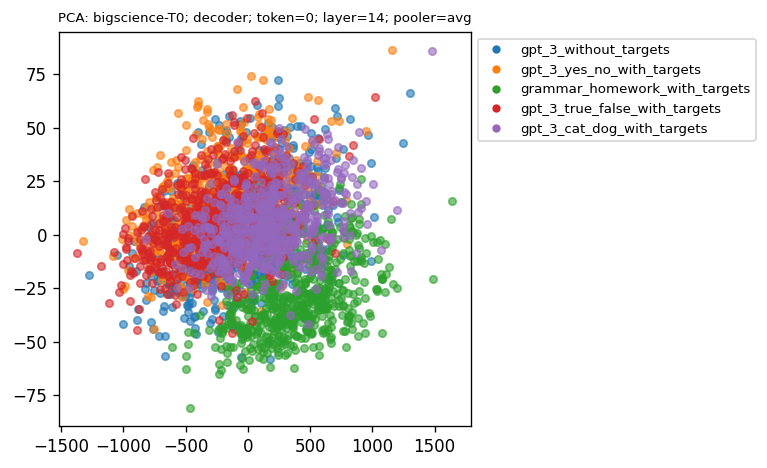



token: 0	layer: 15


Reading embeddings: 100%|██████████| 638/638 [00:00<00:00, 4925.12it/s]


(3190, 4096) (3190,)
PCA for prompts: ['gpt_3_without_targets', 'gpt_3_yes_no_with_targets', 'grammar_homework_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets']
(3190, 2)
model:bigscience-T0; module:decoder; token:0; layer:15; n_components: 2; variance explained: [0.9880616  0.00373427]
0.9917959


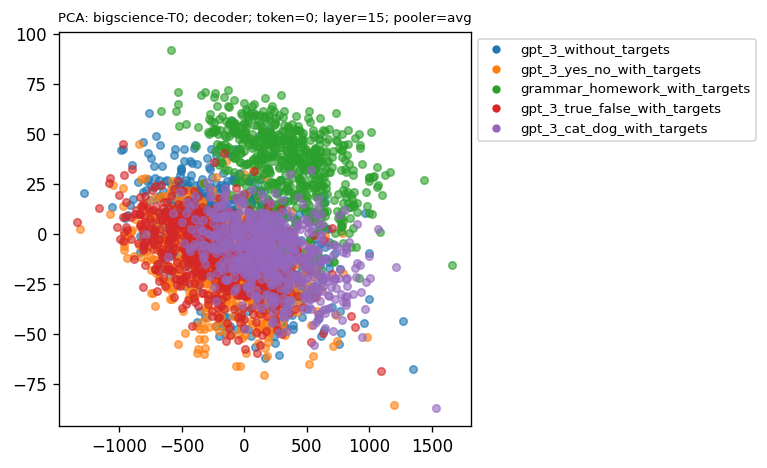



token: 0	layer: 16


Reading embeddings: 100%|██████████| 638/638 [00:00<00:00, 5629.95it/s]


(3190, 4096) (3190,)
PCA for prompts: ['gpt_3_without_targets', 'gpt_3_yes_no_with_targets', 'grammar_homework_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets']
(3190, 2)
model:bigscience-T0; module:decoder; token:0; layer:16; n_components: 2; variance explained: [0.9849763  0.00403902]
0.9890153


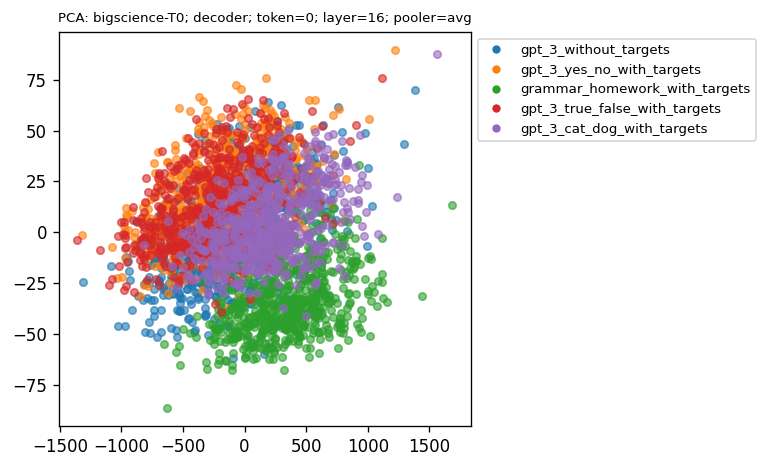



token: 0	layer: 17


Reading embeddings: 100%|██████████| 638/638 [00:00<00:00, 5721.73it/s]


(3190, 4096) (3190,)
PCA for prompts: ['gpt_3_without_targets', 'gpt_3_yes_no_with_targets', 'grammar_homework_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets']
(3190, 2)
model:bigscience-T0; module:decoder; token:0; layer:17; n_components: 2; variance explained: [0.98492646 0.00400277]
0.9889292


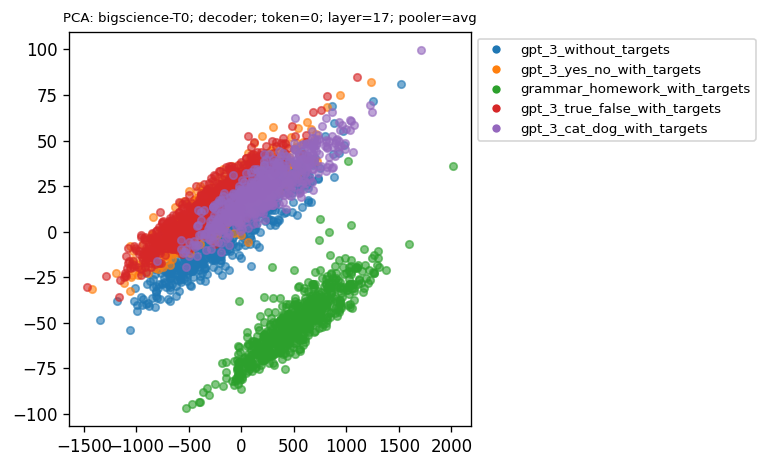



token: 0	layer: 18


Reading embeddings: 100%|██████████| 638/638 [00:00<00:00, 5849.66it/s]


(3190, 4096) (3190,)
PCA for prompts: ['gpt_3_without_targets', 'gpt_3_yes_no_with_targets', 'grammar_homework_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets']
(3190, 2)
model:bigscience-T0; module:decoder; token:0; layer:18; n_components: 2; variance explained: [0.9354393  0.01125384]
0.9466931


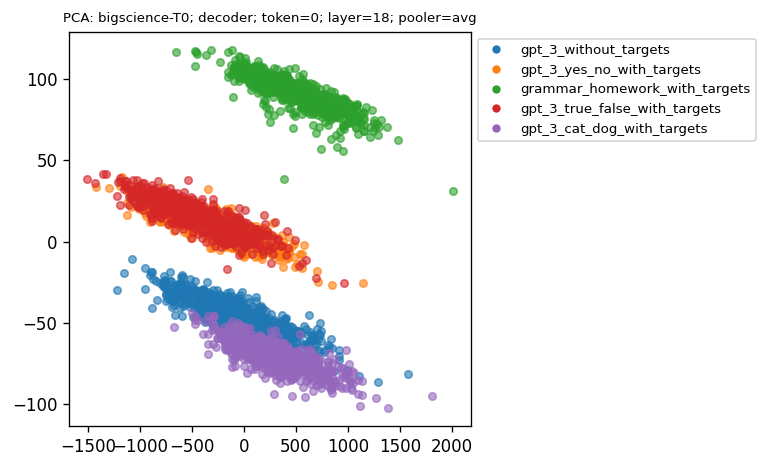



token: 0	layer: 19


Reading embeddings: 100%|██████████| 638/638 [00:00<00:00, 5751.34it/s]


(3190, 4096) (3190,)
PCA for prompts: ['gpt_3_without_targets', 'gpt_3_yes_no_with_targets', 'grammar_homework_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets']
(3190, 2)
model:bigscience-T0; module:decoder; token:0; layer:19; n_components: 2; variance explained: [0.8092848  0.04065675]
0.84994155


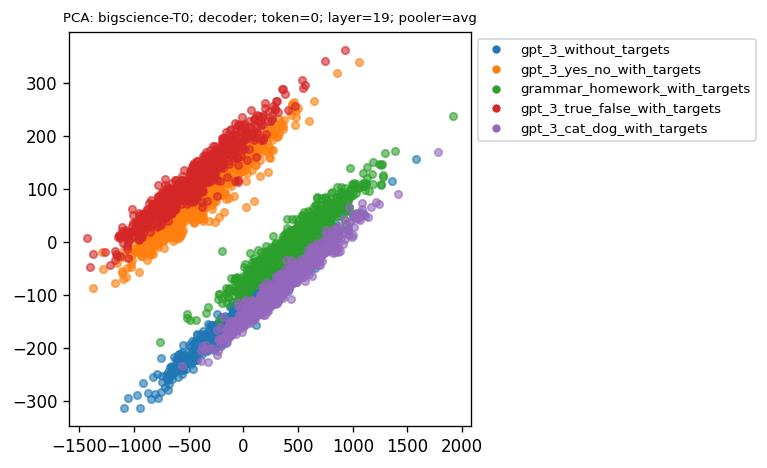



token: 0	layer: 20


Reading embeddings: 100%|██████████| 638/638 [00:00<00:00, 5625.02it/s]


(3190, 4096) (3190,)
PCA for prompts: ['gpt_3_without_targets', 'gpt_3_yes_no_with_targets', 'grammar_homework_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets']
(3190, 2)
model:bigscience-T0; module:decoder; token:0; layer:20; n_components: 2; variance explained: [0.5671026  0.11518399]
0.6822866


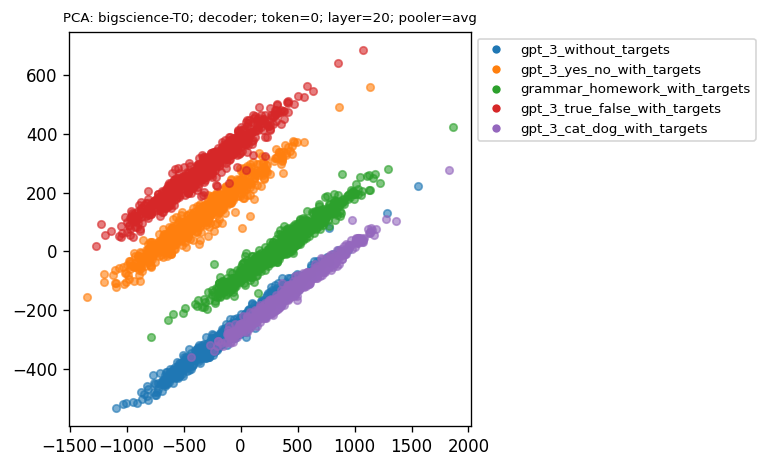



token: 0	layer: 21


Reading embeddings: 100%|██████████| 638/638 [00:00<00:00, 5686.41it/s]


(3190, 4096) (3190,)
PCA for prompts: ['gpt_3_without_targets', 'gpt_3_yes_no_with_targets', 'grammar_homework_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets']
(3190, 2)
model:bigscience-T0; module:decoder; token:0; layer:21; n_components: 2; variance explained: [0.44561243 0.10637584]
0.55198824


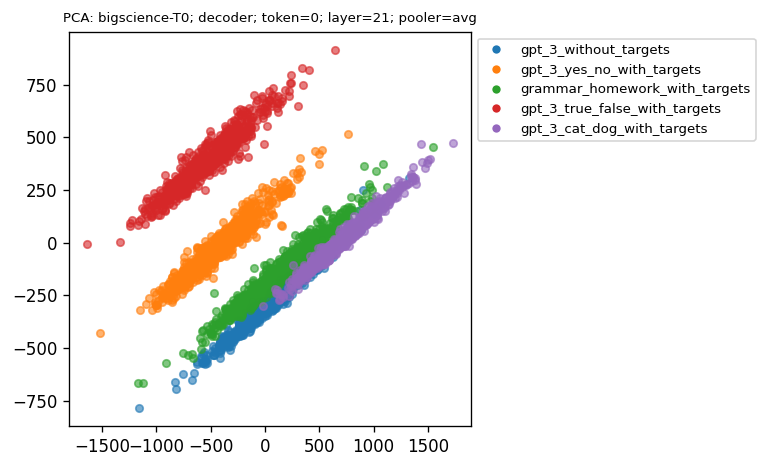



token: 0	layer: 22


Reading embeddings: 100%|██████████| 638/638 [00:00<00:00, 5381.13it/s]


(3190, 4096) (3190,)
PCA for prompts: ['gpt_3_without_targets', 'gpt_3_yes_no_with_targets', 'grammar_homework_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets']
(3190, 2)
model:bigscience-T0; module:decoder; token:0; layer:22; n_components: 2; variance explained: [0.48300162 0.12489978]
0.6079014


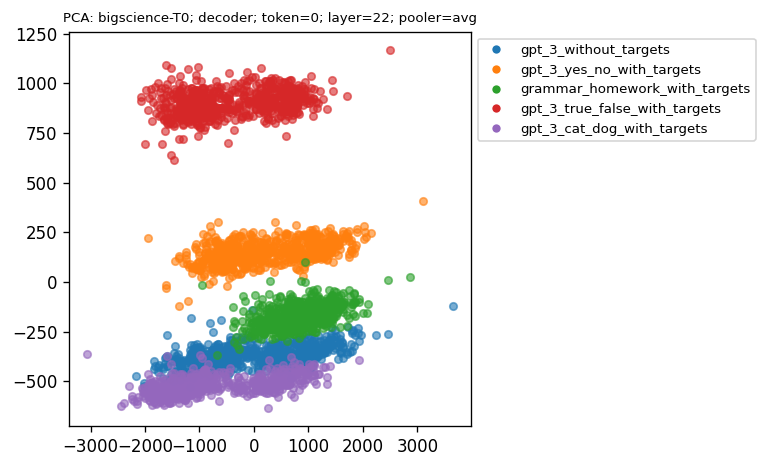



token: 0	layer: 23


Reading embeddings: 100%|██████████| 638/638 [00:00<00:00, 5734.26it/s]


(3190, 4096) (3190,)
PCA for prompts: ['gpt_3_without_targets', 'gpt_3_yes_no_with_targets', 'grammar_homework_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets']
(3190, 2)
model:bigscience-T0; module:decoder; token:0; layer:23; n_components: 2; variance explained: [0.5684837  0.04322364]
0.6117073


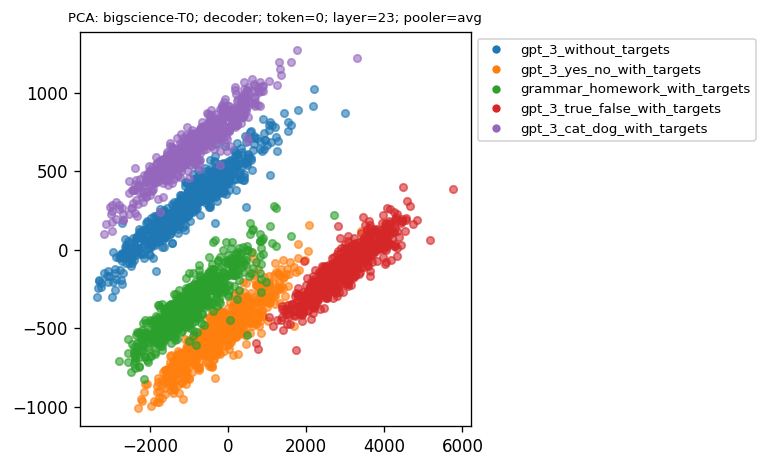



token: 0	layer: 24


Reading embeddings: 100%|██████████| 638/638 [00:00<00:00, 4608.90it/s]


(3190, 4096) (3190,)
PCA for prompts: ['gpt_3_without_targets', 'gpt_3_yes_no_with_targets', 'grammar_homework_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets']
(3190, 2)
model:bigscience-T0; module:decoder; token:0; layer:24; n_components: 2; variance explained: [0.7567289  0.04052026]
0.79724914


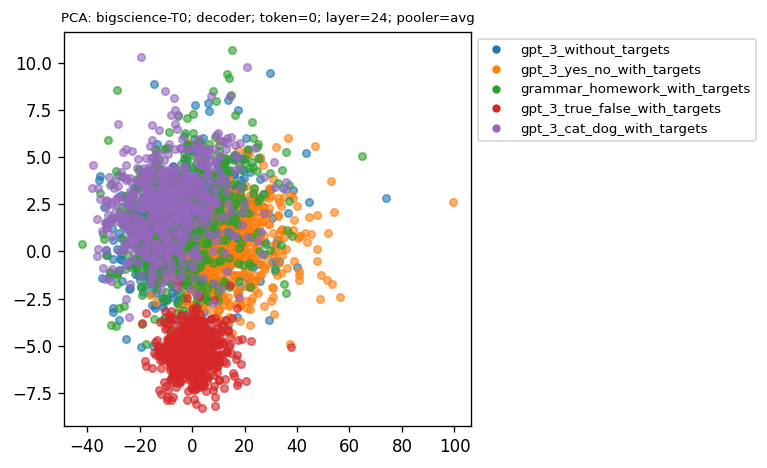



token: 1	layer: 0


Reading embeddings: 100%|██████████| 638/638 [00:00<00:00, 5778.11it/s]


(3190, 4096) (3190,)
PCA for prompts: ['gpt_3_without_targets', 'gpt_3_yes_no_with_targets', 'grammar_homework_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets']
(3190, 2)
model:bigscience-T0; module:decoder; token:1; layer:0; n_components: 2; variance explained: [0.703318   0.11746647]
0.82078445


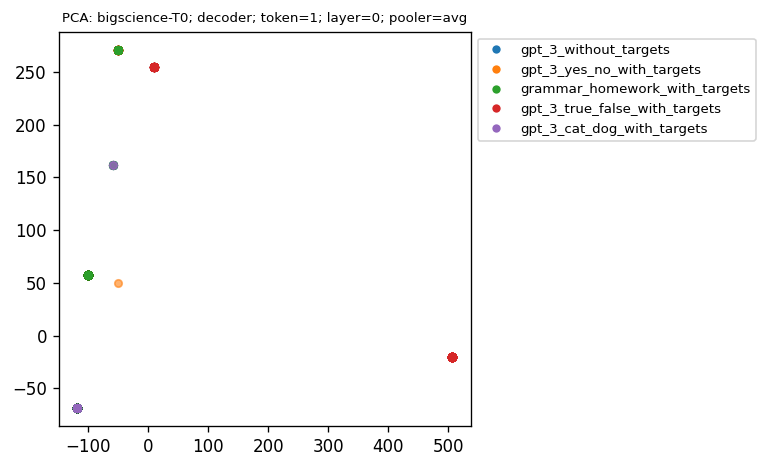



token: 1	layer: 1


Reading embeddings: 100%|██████████| 638/638 [00:00<00:00, 5885.59it/s]


(3190, 4096) (3190,)
PCA for prompts: ['gpt_3_without_targets', 'gpt_3_yes_no_with_targets', 'grammar_homework_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets']
(3190, 2)
model:bigscience-T0; module:decoder; token:1; layer:1; n_components: 2; variance explained: [0.72473    0.11468787]
0.8394179


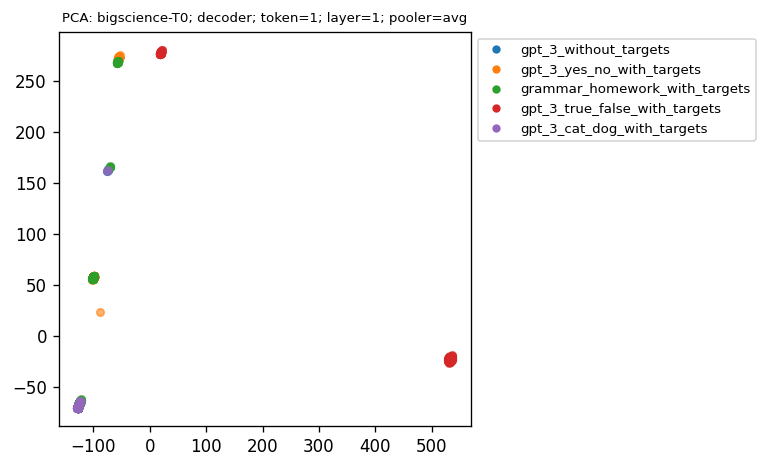



token: 1	layer: 2


Reading embeddings: 100%|██████████| 638/638 [00:00<00:00, 5888.19it/s]


(3190, 4096) (3190,)
PCA for prompts: ['gpt_3_without_targets', 'gpt_3_yes_no_with_targets', 'grammar_homework_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets']
(3190, 2)
model:bigscience-T0; module:decoder; token:1; layer:2; n_components: 2; variance explained: [0.7957123 0.0955811]
0.8912934


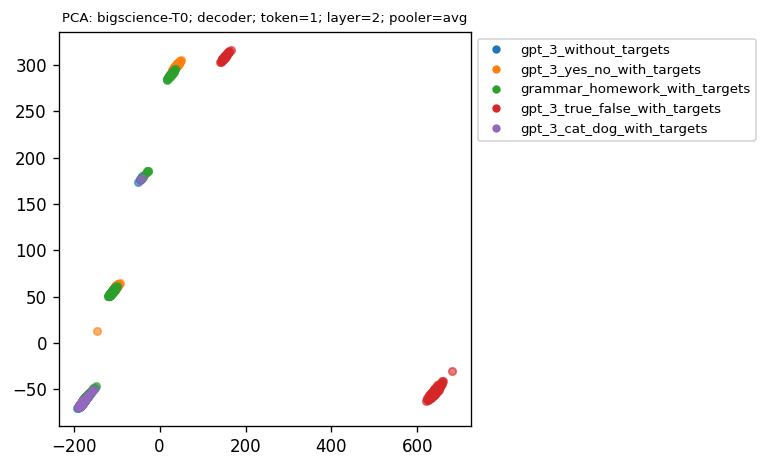



token: 1	layer: 3


Reading embeddings: 100%|██████████| 638/638 [00:00<00:00, 5929.19it/s]


(3190, 4096) (3190,)
PCA for prompts: ['gpt_3_without_targets', 'gpt_3_yes_no_with_targets', 'grammar_homework_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets']
(3190, 2)
model:bigscience-T0; module:decoder; token:1; layer:3; n_components: 2; variance explained: [0.88652897 0.05649491]
0.94302386


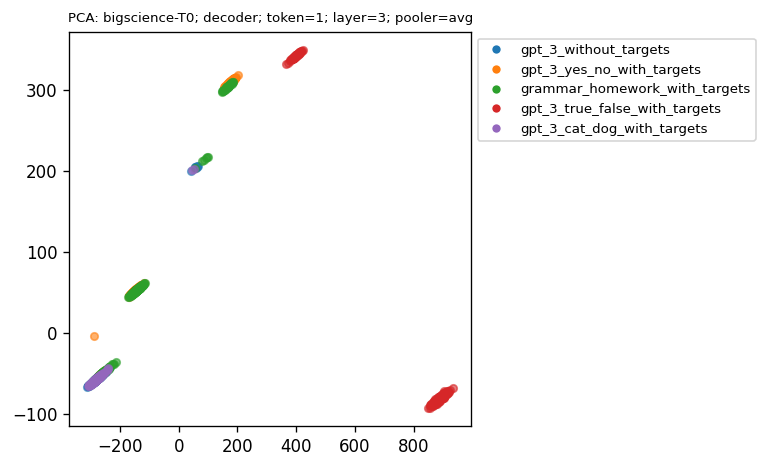



token: 1	layer: 4


Reading embeddings: 100%|██████████| 638/638 [00:00<00:00, 4900.66it/s]


(3190, 4096) (3190,)
PCA for prompts: ['gpt_3_without_targets', 'gpt_3_yes_no_with_targets', 'grammar_homework_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets']
(3190, 2)
model:bigscience-T0; module:decoder; token:1; layer:4; n_components: 2; variance explained: [0.94013333 0.03018512]
0.97031844


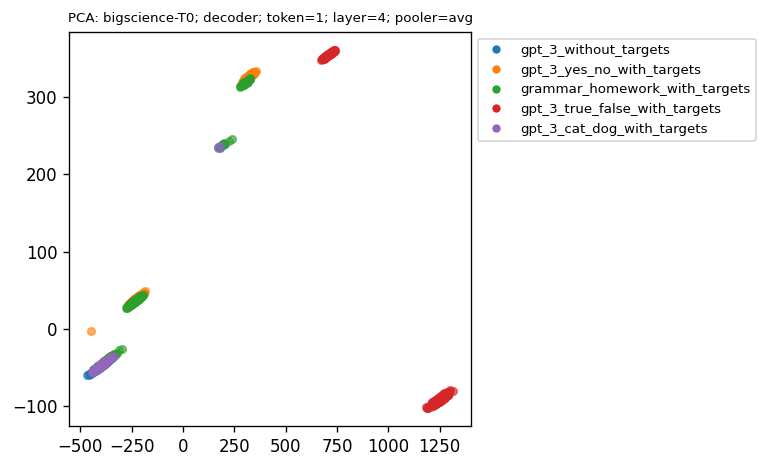



token: 1	layer: 5


Reading embeddings: 100%|██████████| 638/638 [00:00<00:00, 5695.88it/s]


(3190, 4096) (3190,)
PCA for prompts: ['gpt_3_without_targets', 'gpt_3_yes_no_with_targets', 'grammar_homework_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets']
(3190, 2)
model:bigscience-T0; module:decoder; token:1; layer:5; n_components: 2; variance explained: [0.9609502  0.02019962]
0.9811498


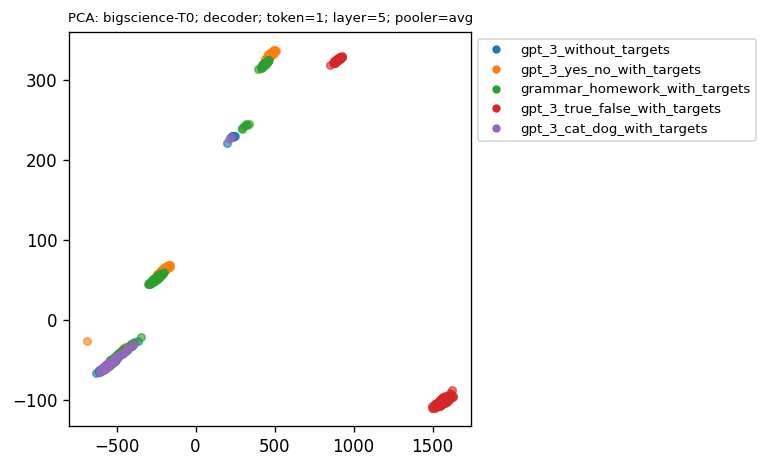



token: 1	layer: 6


Reading embeddings: 100%|██████████| 638/638 [00:00<00:00, 5561.78it/s]


(3190, 4096) (3190,)
PCA for prompts: ['gpt_3_without_targets', 'gpt_3_yes_no_with_targets', 'grammar_homework_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets']
(3190, 2)
model:bigscience-T0; module:decoder; token:1; layer:6; n_components: 2; variance explained: [0.970755   0.01510906]
0.98586404


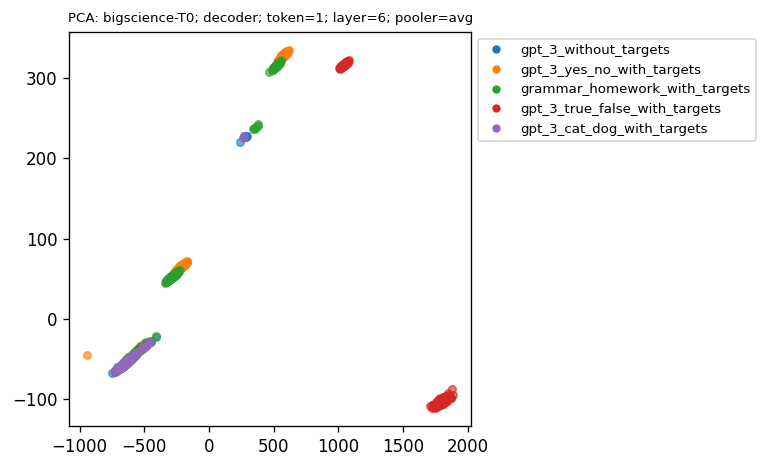



token: 1	layer: 7


Reading embeddings: 100%|██████████| 638/638 [00:00<00:00, 5657.51it/s]


(3190, 4096) (3190,)
PCA for prompts: ['gpt_3_without_targets', 'gpt_3_yes_no_with_targets', 'grammar_homework_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets']
(3190, 2)
model:bigscience-T0; module:decoder; token:1; layer:7; n_components: 2; variance explained: [0.9802335  0.01092492]
0.9911584


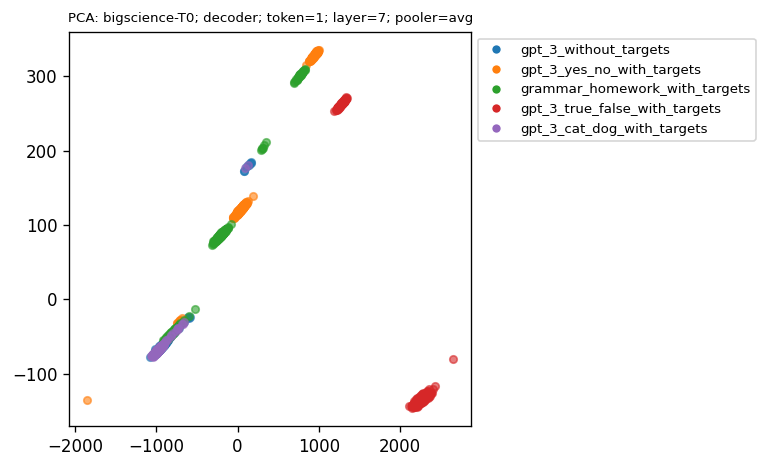



token: 1	layer: 8


Reading embeddings: 100%|██████████| 638/638 [00:00<00:00, 5951.58it/s]


(3190, 4096) (3190,)
PCA for prompts: ['gpt_3_without_targets', 'gpt_3_yes_no_with_targets', 'grammar_homework_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets']
(3190, 2)
model:bigscience-T0; module:decoder; token:1; layer:8; n_components: 2; variance explained: [0.9828574  0.00924833]
0.9921057


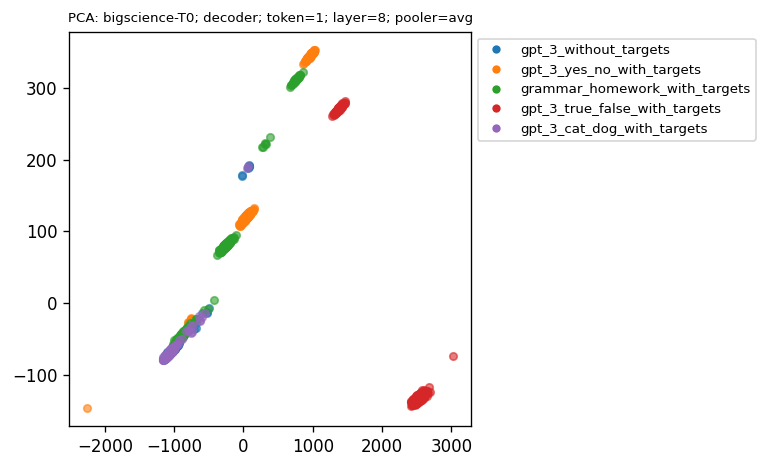



token: 1	layer: 9


Reading embeddings: 100%|██████████| 638/638 [00:00<00:00, 5670.40it/s]


(3190, 4096) (3190,)
PCA for prompts: ['gpt_3_without_targets', 'gpt_3_yes_no_with_targets', 'grammar_homework_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets']
(3190, 2)
model:bigscience-T0; module:decoder; token:1; layer:9; n_components: 2; variance explained: [0.9854274  0.00765104]
0.9930784


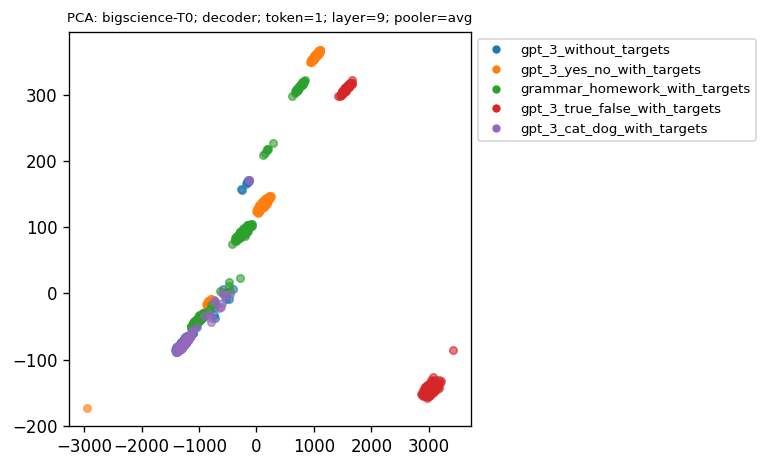



token: 1	layer: 10


Reading embeddings: 100%|██████████| 638/638 [00:00<00:00, 5587.24it/s]


(3190, 4096) (3190,)
PCA for prompts: ['gpt_3_without_targets', 'gpt_3_yes_no_with_targets', 'grammar_homework_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets']
(3190, 2)
model:bigscience-T0; module:decoder; token:1; layer:10; n_components: 2; variance explained: [0.9869259  0.00663239]
0.9935583


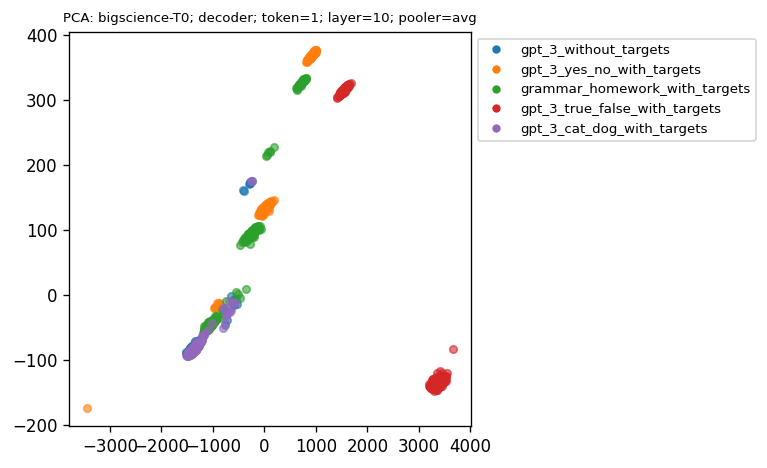



token: 1	layer: 11


Reading embeddings: 100%|██████████| 638/638 [00:00<00:00, 4897.29it/s]


(3190, 4096) (3190,)
PCA for prompts: ['gpt_3_without_targets', 'gpt_3_yes_no_with_targets', 'grammar_homework_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets']
(3190, 2)
model:bigscience-T0; module:decoder; token:1; layer:11; n_components: 2; variance explained: [0.9871007  0.00635904]
0.99345976


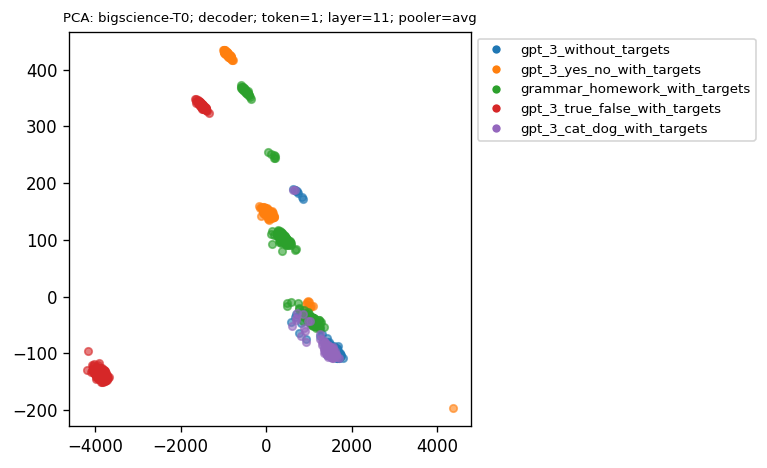



token: 1	layer: 12


Reading embeddings: 100%|██████████| 638/638 [00:00<00:00, 5841.79it/s]


(3190, 4096) (3190,)
PCA for prompts: ['gpt_3_without_targets', 'gpt_3_yes_no_with_targets', 'grammar_homework_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets']
(3190, 2)
model:bigscience-T0; module:decoder; token:1; layer:12; n_components: 2; variance explained: [0.98597145 0.00654017]
0.99251163


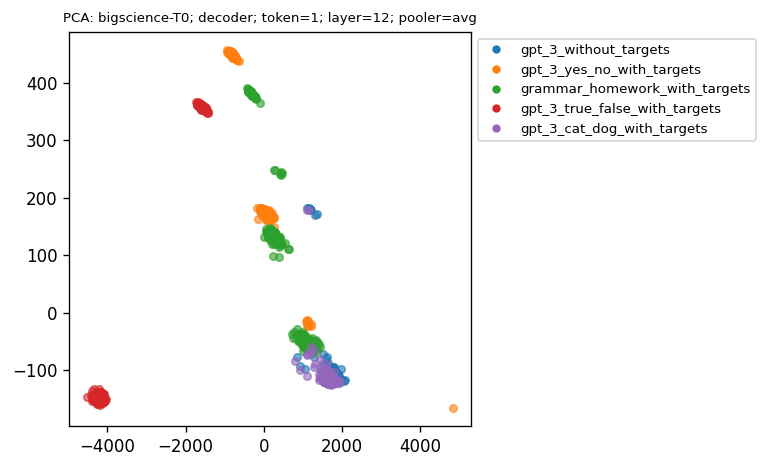



token: 1	layer: 13


Reading embeddings: 100%|██████████| 638/638 [00:00<00:00, 4835.12it/s]


(3190, 4096) (3190,)
PCA for prompts: ['gpt_3_without_targets', 'gpt_3_yes_no_with_targets', 'grammar_homework_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets']
(3190, 2)
model:bigscience-T0; module:decoder; token:1; layer:13; n_components: 2; variance explained: [0.98016125 0.00913415]
0.9892954


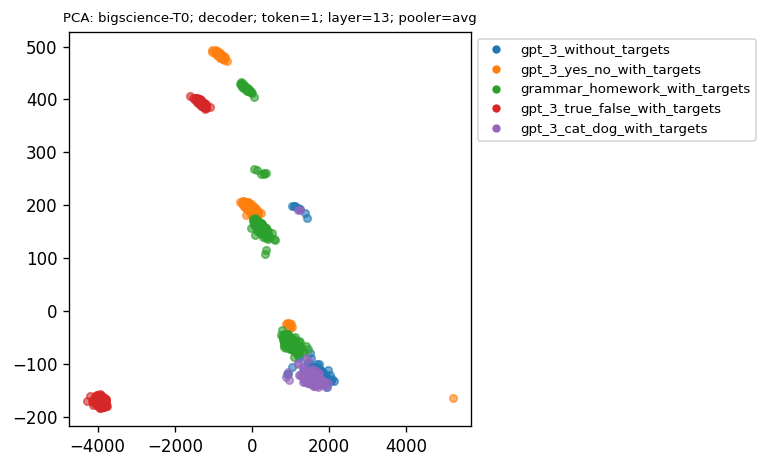



token: 1	layer: 14


Reading embeddings: 100%|██████████| 638/638 [00:00<00:00, 5849.99it/s]


(3190, 4096) (3190,)
PCA for prompts: ['gpt_3_without_targets', 'gpt_3_yes_no_with_targets', 'grammar_homework_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets']
(3190, 2)
model:bigscience-T0; module:decoder; token:1; layer:14; n_components: 2; variance explained: [0.9712002  0.01311168]
0.9843119


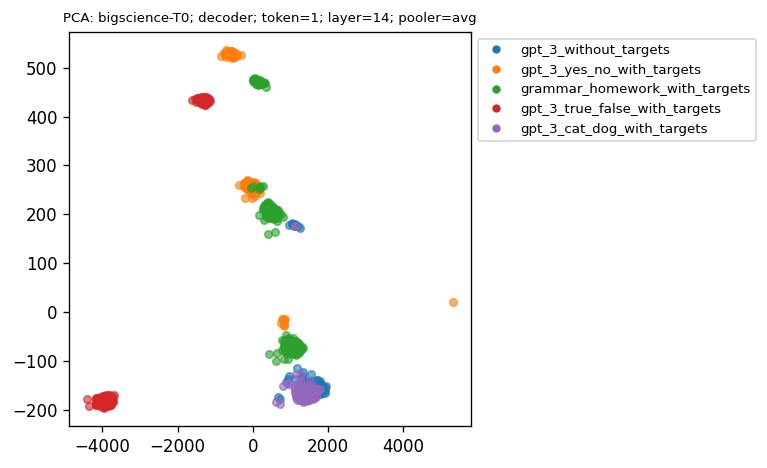



token: 1	layer: 15


Reading embeddings: 100%|██████████| 638/638 [00:00<00:00, 5452.74it/s]


(3190, 4096) (3190,)
PCA for prompts: ['gpt_3_without_targets', 'gpt_3_yes_no_with_targets', 'grammar_homework_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets']
(3190, 2)
model:bigscience-T0; module:decoder; token:1; layer:15; n_components: 2; variance explained: [0.94445205 0.02689469]
0.97134674


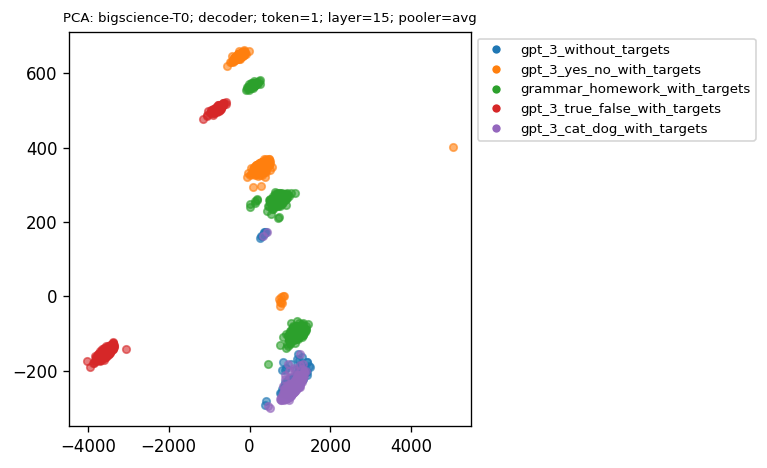



token: 1	layer: 16


Reading embeddings: 100%|██████████| 638/638 [00:00<00:00, 5527.02it/s]


(3190, 4096) (3190,)
PCA for prompts: ['gpt_3_without_targets', 'gpt_3_yes_no_with_targets', 'grammar_homework_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets']
(3190, 2)
model:bigscience-T0; module:decoder; token:1; layer:16; n_components: 2; variance explained: [0.86501366 0.06673454]
0.9317482


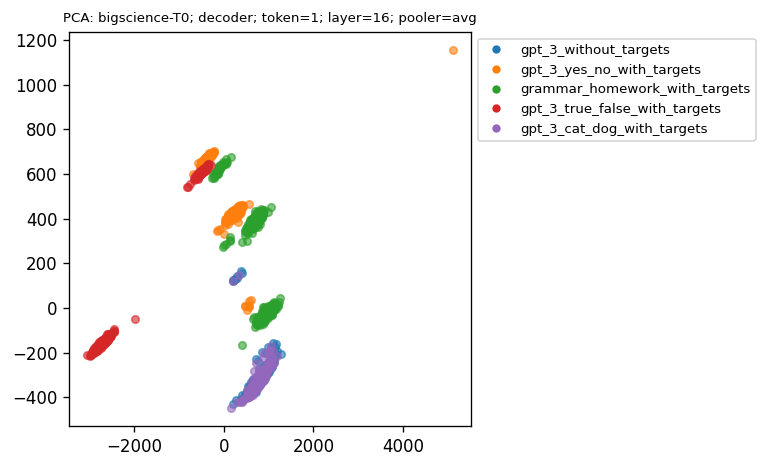



token: 1	layer: 17


Reading embeddings: 100%|██████████| 638/638 [00:00<00:00, 5681.61it/s]


(3190, 4096) (3190,)
PCA for prompts: ['gpt_3_without_targets', 'gpt_3_yes_no_with_targets', 'grammar_homework_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets']
(3190, 2)
model:bigscience-T0; module:decoder; token:1; layer:17; n_components: 2; variance explained: [0.7707646  0.11920907]
0.88997364


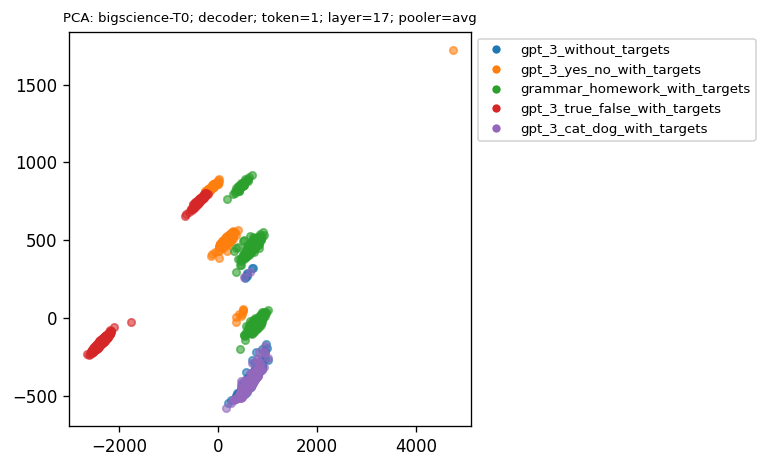



token: 1	layer: 18


Reading embeddings: 100%|██████████| 638/638 [00:00<00:00, 5619.72it/s]


(3190, 4096) (3190,)
PCA for prompts: ['gpt_3_without_targets', 'gpt_3_yes_no_with_targets', 'grammar_homework_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets']
(3190, 2)
model:bigscience-T0; module:decoder; token:1; layer:18; n_components: 2; variance explained: [0.6860519 0.1863287]
0.8723806


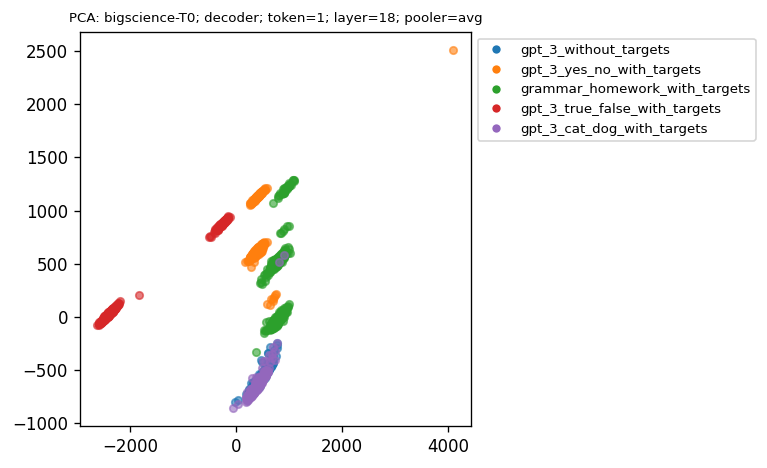



token: 1	layer: 19


Reading embeddings: 100%|██████████| 638/638 [00:00<00:00, 5293.18it/s]


(3190, 4096) (3190,)
PCA for prompts: ['gpt_3_without_targets', 'gpt_3_yes_no_with_targets', 'grammar_homework_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets']
(3190, 2)
model:bigscience-T0; module:decoder; token:1; layer:19; n_components: 2; variance explained: [0.515806 0.344723]
0.860529


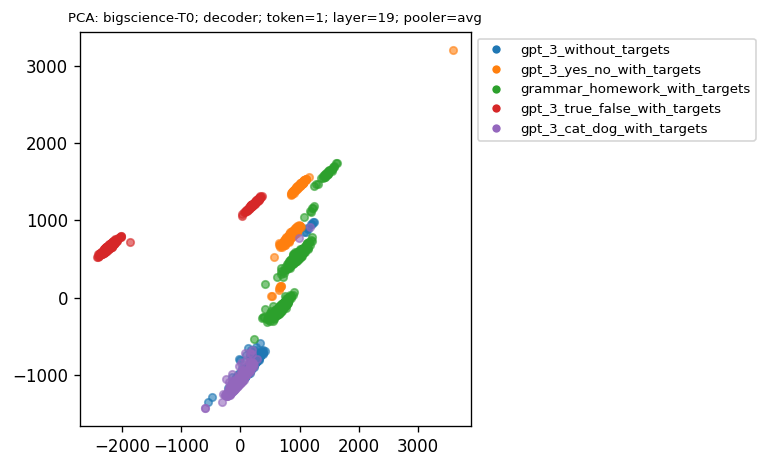



token: 1	layer: 20


Reading embeddings: 100%|██████████| 638/638 [00:00<00:00, 5373.09it/s]


(3190, 4096) (3190,)
PCA for prompts: ['gpt_3_without_targets', 'gpt_3_yes_no_with_targets', 'grammar_homework_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets']
(3190, 2)
model:bigscience-T0; module:decoder; token:1; layer:20; n_components: 2; variance explained: [0.5598792  0.31339678]
0.873276


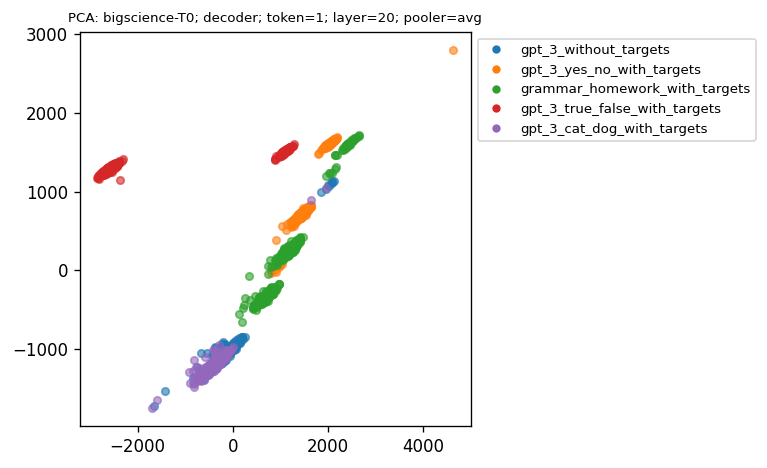



token: 1	layer: 21


Reading embeddings: 100%|██████████| 638/638 [00:00<00:00, 4695.71it/s]


(3190, 4096) (3190,)
PCA for prompts: ['gpt_3_without_targets', 'gpt_3_yes_no_with_targets', 'grammar_homework_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets']
(3190, 2)
model:bigscience-T0; module:decoder; token:1; layer:21; n_components: 2; variance explained: [0.5331102 0.2739859]
0.8070961


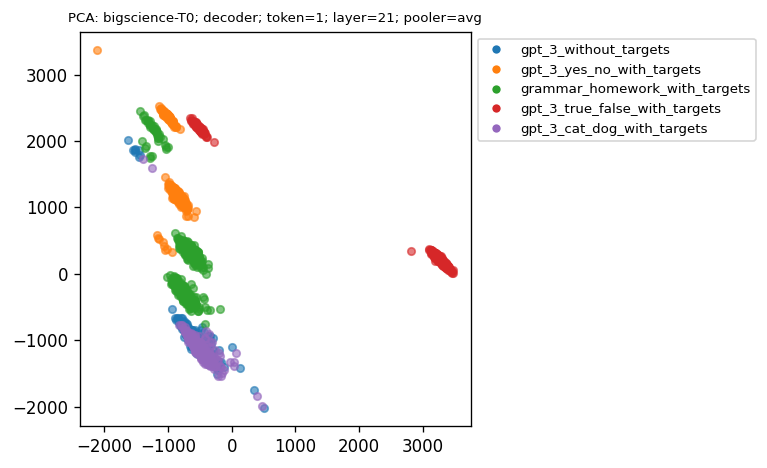



token: 1	layer: 22


Reading embeddings: 100%|██████████| 638/638 [00:00<00:00, 5320.20it/s]


(3190, 4096) (3190,)
PCA for prompts: ['gpt_3_without_targets', 'gpt_3_yes_no_with_targets', 'grammar_homework_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets']
(3190, 2)
model:bigscience-T0; module:decoder; token:1; layer:22; n_components: 2; variance explained: [0.5202592 0.2744113]
0.79467046


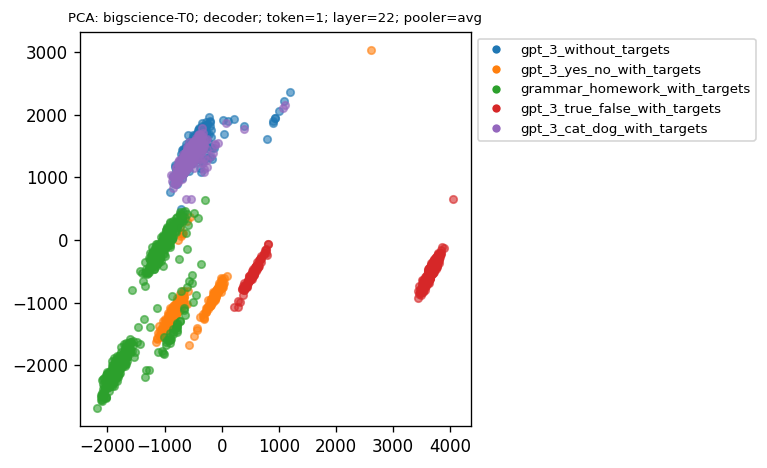



token: 1	layer: 23


Reading embeddings: 100%|██████████| 638/638 [00:00<00:00, 5680.88it/s]


(3190, 4096) (3190,)
PCA for prompts: ['gpt_3_without_targets', 'gpt_3_yes_no_with_targets', 'grammar_homework_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets']
(3190, 2)
model:bigscience-T0; module:decoder; token:1; layer:23; n_components: 2; variance explained: [0.4797821  0.32995212]
0.8097342


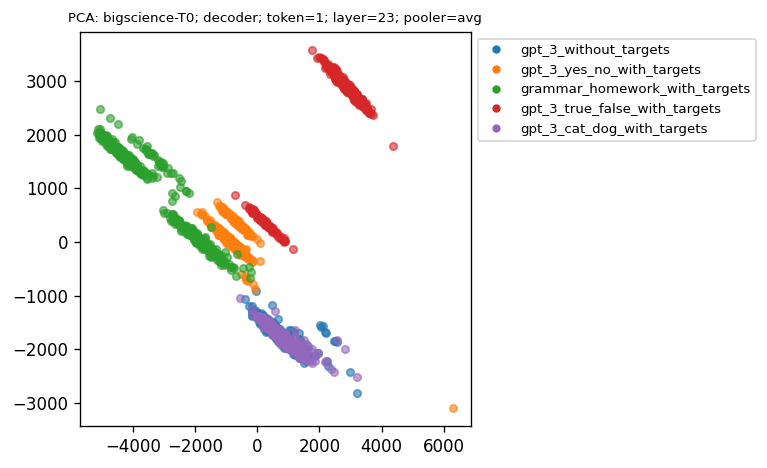



token: 1	layer: 24


Reading embeddings: 100%|██████████| 638/638 [00:00<00:00, 4903.66it/s]


(3190, 4096) (3190,)
PCA for prompts: ['gpt_3_without_targets', 'gpt_3_yes_no_with_targets', 'grammar_homework_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets']
(3190, 2)
model:bigscience-T0; module:decoder; token:1; layer:24; n_components: 2; variance explained: [0.7923798  0.12854026]
0.9209201


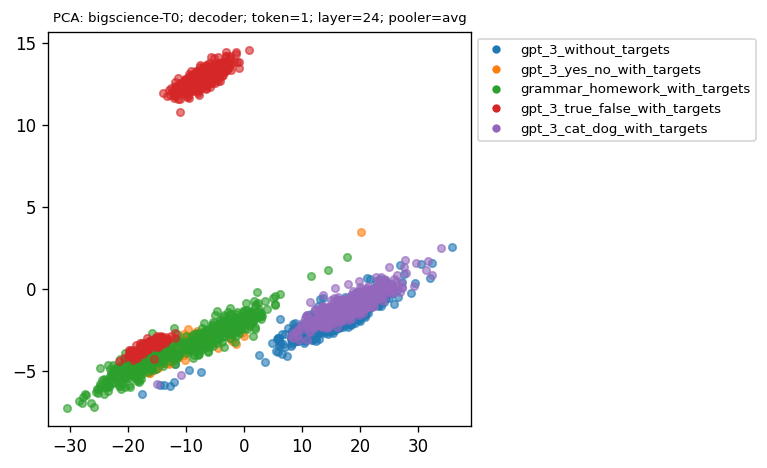

In [8]:
cmap = matplotlib.cm.get_cmap('tab10')
# cmap = matplotlib.cm.get_cmap('tab20')
colors = cmap.colors

for t in range(2):
# for t in range(1):
    # for layer in range(0, 10):
    for layer in range(0, 25):
    # for layer in range(24, 25):
        print(f"token: {t}\tlayer: {layer}")
        file_names, prompt_names = [], []

        for _, row in df.iterrows():
            if row['name'] in use_pattern:
                file_names.append(f"{task}/{model}/{module}/{row['name']}/hidden_represenations_t{t}_layer{layer}_avg.hdf5",)
                prompt_names.append(row['name'])


        # load hidden representations from hdf5 file
        representations = None
        classes = []
        n_sequences = 0

        for idx, file_name in enumerate(file_names):
            hidden_representations = load_hidden_representations_from_hdf5(os.path.join(log_dir, file_name))
            # print(hidden_representations.shape)
            n_sequences = hidden_representations.shape[0]

            if representations is None:
                representations = hidden_representations
            else:
                representations = np.concatenate((representations, hidden_representations), axis=0)

            classes += n_sequences * [idx] # assign representations to classes
        
        classes = np.asarray(classes)

        X, y = representations, classes
        # shuffle representations and classes
        # X, y = unison_shuffled_copies(representations, classes)
        print(X.shape, y.shape)

        # perform PCA on hidden representations
        print('PCA for prompts:', prompt_names)

        for n_components in range(2, 3):
            pca = PCA(n_components=n_components)
            X_pca = pca.fit(X).transform(X)
            print(X_pca.shape)

            # variance explained by each of the principal components
            print(f"model:{model}; module:{module}; token:{t}; layer:{layer}; n_components: {n_components}; variance explained: {pca.explained_variance_ratio_}")
            print(np.sum(pca.explained_variance_ratio_))

            # plot PCA embeddings
            fig, axes = plt.subplots(1, 1, figsize=(6.5,4), dpi=120)
            legend_elements= []

            for idx, file_name in enumerate(file_names):
                x, y = X_pca[n_sequences*idx:n_sequences*(idx + 1), 0], X_pca[n_sequences*idx:n_sequences*(idx + 1), 1]
                axes.scatter(x, y, alpha=0.6, s=[20.0], color=colors[idx])

                # create legend element manually
                legend_elements.append(Line2D([0], [0], marker='o', color='w', label=prompt_names[idx], markerfacecolor=colors[idx], markersize=6))
        
            axes.set_title(f"PCA: {model}; {module}; token={t}; layer={layer}; pooler=avg", fontsize=8)
            axes.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.0, 1.0), fancybox=True, shadow=False, fontsize=8)

            plt.tight_layout()

            plt.show()
            plt.close();
        
        print('\n')
